We then used the model trained previously to classify all historical maps from our study area. In order to reduce noise and make predictions smoother, some post-processing steps are required. For this, we used morphological operations such as **closing**, and **erosion**, as well as **low-pass filtering** with suitable kernel sizes.

In [ ]:
import cv2
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio.mask as rio_mask
from shapely.geometry import box
from pathlib import Path
import os
from tqdm import tqdm
import fiona
from rasterio import features
from rasterio.enums import Resampling
from itertools import product
from shapely.geometry import Polygon
from skimage.morphology import skeletonize, medial_axis, thin

In [ ]:
def polygonize(fn, outpath, target_class, scale_factor=1):
    with rio.open(fn) as src:
        im = src.read(out_shape=(src.count, int(src.height*scale_factor),int(src.width*scale_factor)),
                      resampling=Resampling.mode)[target_class -1]
        im[im !=  0] = 1
        mask = im == 1
        tfm = src.transform * src.transform.scale((src.width/im.shape[-1]), (src.height/im.shape[-2]))
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                   for i, (s, v) in enumerate(features.shapes(im, mask==mask, transform=tfm))
                   if v == 1)
        with fiona.open(outpath, 'w', driver='GeoJSON',
                        crs='EPSG:3067',
                        schema={'properties': [('raster_val', 'int')],
                                'geometry': 'Polygon'}) as dst:
            dst.writerecords(results)

In [ ]:
def make_grid(area, cell):
    xmin, ymin, xmax, ymax = area.total_bounds
    
    cols = list(np.arange(xmin, xmax+cell, cell))
    rows = list(np.arange(ymin, ymax+cell, cell))
    
    polys = []
    names = []
    for (C,x), (R,y) in product(enumerate(cols[:-1]), enumerate(rows[:-1])):
        polys.append(Polygon([(x,y), (x+cell, y), (x+cell,y+cell),(x, y+cell)]))
        names.append(f'R{R}C{C}')
    return gpd.GeoDataFrame({'geometry':polys, 'cellid':names}, crs=area.crs)

# Evaluate results before post-processing

In [ ]:
from sklearn.metrics import precision_score, recall_score

def dice(targs, preds, cls_id):
    inter = (np.where(targs==cls_id, 1, 0)*np.where(preds==cls_id, 1, 0)).sum()
    union = (np.where(targs==cls_id, 1, 0)+np.where(preds==cls_id, 1, 0)).sum()
    return 2 * inter/union if union > 0 else None

def jaccard(targs, preds, cls_id):
    inter = (np.where(targs==cls_id, 1, 0)*np.where(preds==cls_id, 1, 0)).sum()
    union = (np.where(targs==cls_id, 1, 0)+np.where(preds==cls_id, 1, 0)).sum()
    return inter/(union-inter) if union > 0 else None

def pre(targs, preds, cls_id):
    return precision_score(np.where(targs==cls_id, 1, 0).flatten(), np.where(preds==cls_id, 1, 0).flatten())
    
def rec(targs, preds, cls_id):
    return recall_score(np.where(targs==cls_id, 1, 0).flatten(), np.where(preds==cls_id, 1, 0).flatten())

In [ ]:
with rio.open('../data/reference_masks/val_mask_1965.tif') as test_src:
    bounds_65 = test_src.bounds
    with rio.open('../results/raw/213405_1965.tif') as pred_src:
        bounds_test = pred_src.bounds
        preds_65, _ = rio_mask.mask(pred_src, [box(*bounds_test).intersection(box(*bounds_65))], crop=True)
        preds_65 = preds_65[0]
    test_mask_65, _ = rio_mask.mask(test_src, [box(*bounds_test).intersection(box(*bounds_65))], crop=True)
    test_mask_65 = test_mask_65[0]


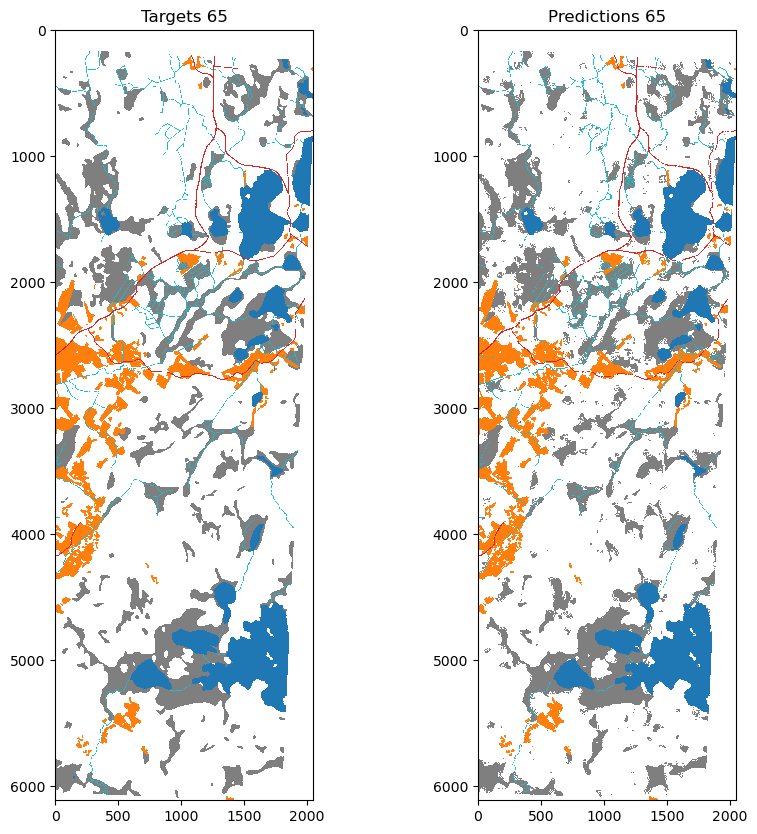

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'tab:orange', 'tab:grey', 'tab:red', 'tab:cyan', 'tab:blue'])
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(test_mask_65, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[0].set_title('Targets 65')
axs[1].imshow(preds_65, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[1].set_title('Predictions 65')
plt.show()

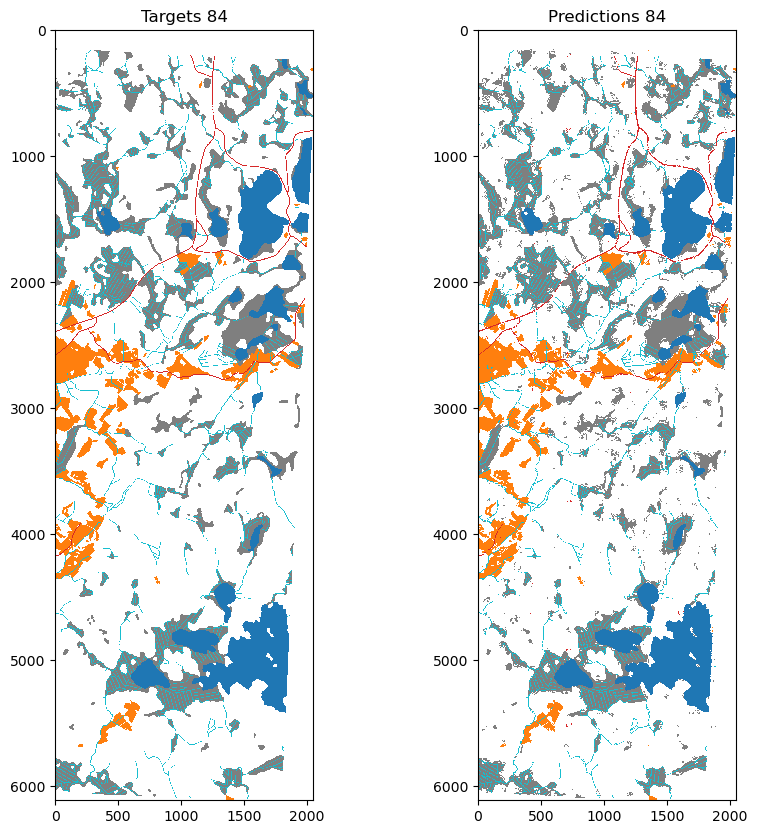

In [ ]:
with rio.open('../data/reference_masks/val_mask_1984.tif') as test_src:
    bounds_84 = test_src.bounds
    with rio.open('../results/raw/213405_1984.tif') as pred_src:
        bounds_test = pred_src.bounds
        preds_84, _ = rio_mask.mask(pred_src, [box(*bounds_test).intersection(box(*bounds_84))], crop=True)
        preds_84 = preds_84[0]
    test_mask_84, _ = rio_mask.mask(test_src, [box(*bounds_test).intersection(box(*bounds_84))], crop=True)
    test_mask_84 = test_mask_84[0]
    
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(test_mask_84, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[0].set_title('Targets 84')
axs[1].imshow(preds_84, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[1].set_title('Predictions 84')
plt.show()

Evaluate predictions before post-processing.

In [ ]:
classes = ['Fields', 'Mires', 'Roads', 'Watercourses', 'Water bodies']

dices_65 = []
dices_84 = []
ious_65 = []
ious_84 = []
pres_65 = []
pres_84 = []
recs_65 = []
recs_84 = []


for c in range(0,5):
    dice_65 = dice(test_mask_65, preds_65, c+1)
    dice_84 = dice(test_mask_84, preds_84, c+1)
    dices_65.append(dice_65)
    dices_84.append(dice_84)
    
    iou_65 = jaccard(test_mask_65, preds_65, c+1)
    iou_84 = jaccard(test_mask_84, preds_84, c+1)
    ious_65.append(iou_65)
    ious_84.append(iou_84)
    
    pre_65 = pre(test_mask_65, preds_65, c+1)
    pre_84 = pre(test_mask_84, preds_84, c+1)
    pres_65.append(pre_65)
    pres_84.append(pre_84)
    
    rec_65 = rec(test_mask_65, preds_65, c+1)
    rec_84 = rec(test_mask_84, preds_84, c+1)
    recs_65.append(rec_65)
    recs_84.append(rec_84)
    
    print(f'Results for class {classes[c]}:')
    print(f'Dice: 65 map: {dice_65:.3f}, 84 map: {dice_84:.3f}, overall {(dice_65+dice_84)/2:.3f}')
    print(f'Jaccard: 65 map: {iou_65:.3f}, 84 map: {iou_84:.3f}, overall {(iou_65+iou_84)/2:.3f}')
    print(f'Precision: 65 map: {pre_65:.3f}, 84 map: {pre_84:.3f}, overall {(pre_65+pre_84)/2:.3f}')
    print(f'Recall: 65 map: {rec_65:.3f}, 84 map: {rec_84:.3f}, overall {(rec_65+rec_84)/2:.3f}\n')    
    
print(f'Overall results:')
print(f'Dice: 65 map: {sum(dices_65)/5:.3f}, 84 map: {sum(dices_84)/5:.3f}, overall {(sum(dices_65)+sum(dices_84))/10:.3f}')
print(f'Jaccard: 65 map: {sum(ious_65)/5:.3f}, 84 map: {sum(ious_84)/5:.3f}, overall {(sum(ious_65)+sum(ious_84))/10:.3f}')
print(f'Precision: 65 map: {sum(pres_65)/5:.3f}, 84 map: {sum(pres_84)/5:.3f}, overall {(sum(pres_65)+sum(pres_84))/10:.3f}')
print(f'Recall: 65 map: {sum(recs_65)/5:.3f}, 84 map: {sum(recs_84)/5:.3f}, overall {(sum(recs_65)+sum(recs_84))/10:.3f}')

Results for class Fields:
Dice: 65 map: 0.941, 84 map: 0.941, overall 0.941
Jaccard: 65 map: 0.888, 84 map: 0.889, overall 0.889
Precision: 65 map: 0.928, 84 map: 0.931, overall 0.929
Recall: 65 map: 0.954, 84 map: 0.952, overall 0.953

Results for class Mires:
Dice: 65 map: 0.863, 84 map: 0.803, overall 0.833
Jaccard: 65 map: 0.759, 84 map: 0.671, overall 0.715
Precision: 65 map: 0.827, 84 map: 0.767, overall 0.797
Recall: 65 map: 0.902, 84 map: 0.843, overall 0.873

Results for class Roads:
Dice: 65 map: 0.831, 84 map: 0.779, overall 0.805
Jaccard: 65 map: 0.711, 84 map: 0.638, overall 0.674
Precision: 65 map: 0.832, 84 map: 0.734, overall 0.783
Recall: 65 map: 0.830, 84 map: 0.830, overall 0.830

Results for class Watercourses:
Dice: 65 map: 0.709, 84 map: 0.688, overall 0.699
Jaccard: 65 map: 0.550, 84 map: 0.524, overall 0.537
Precision: 65 map: 0.713, 84 map: 0.673, overall 0.693
Recall: 65 map: 0.706, 84 map: 0.703, overall 0.704

Results for class Water bodies:
Dice: 65 map: 0.

# Postprocessing

The postprocessing steps depend on the land cover class and how they are layered in the final products. Roads and watercourses are such classes that the final products for these are line geometries, whereas the other classes can be either raster data or polygon data. Most watercourses (e.g. ditches) do not split mires and fields into multiple sections, whereas roads split these classes into multiple different segments. 

In [ ]:
ex_data = '../results/raw/213406_1965_ei_rajoja.tif'
with rio.open(ex_data) as src:
    data = src.read(1)
    
ex_map = '../data/maps/aligned_maps/213406_1965_ei_rajoja.tif'
with rio.open(ex_map) as src:
    mapdata = np.moveaxis(src.read(), 0, -1)

mapdata = mapdata[32:, 32:]    

data = data[:mapdata.shape[0], :mapdata.shape[1]]

## Fields

Comparison with automatically extracted orange color.

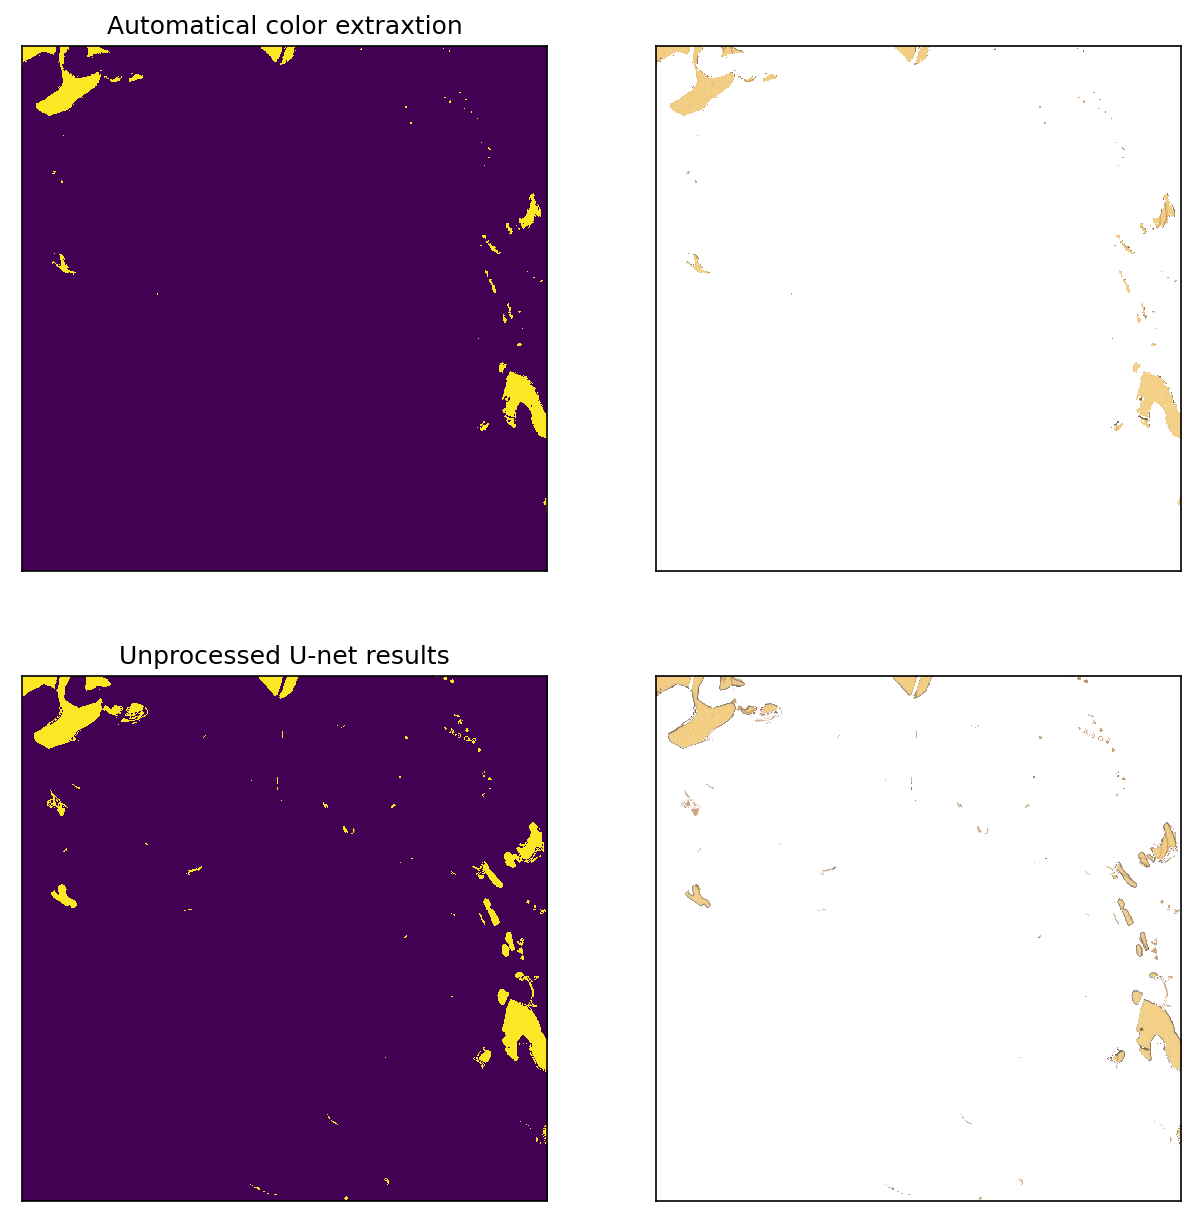

In [ ]:
hsv_field_bot = np.array([15,100,100])
hsv_field_top = np.array([25,255,255])
tempmap = mapdata[2500:3500, 2000:3000,:].copy()

hsv_ex = cv2.cvtColor(tempmap, cv2.COLOR_RGB2HSV)
field_mask = cv2.inRange(hsv_ex, hsv_field_bot, hsv_field_top)
field_mask = field_mask.astype(np.int16)

fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=150)

for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

field_mask[field_mask<128] = 0
field_mask[field_mask>128] = 1
axs[0,0].imshow(field_mask, interpolation='none')
tempmap = mapdata[2500:3500, 2000:3000,:].copy()
temp = tempmap.copy()
temp[field_mask == 0] = 255
axs[0,1].imshow(temp, interpolation='none')

axs[0,0].set_title('Automatical color extraxtion')
axs[1,0].set_title('Unprocessed U-net results')
fields = np.empty(data.shape)
fields = fields.astype(np.uint8)

fields[data==1] = 1
fields = fields[2500:3500, 2000:3000]
axs[1,0].imshow(fields, interpolation='none')
temp = tempmap.copy()
temp[fields == 0] = 255
axs[1,1].imshow(temp, interpolation='none')
plt.show()

During postprocessing, include watercourses for these layers. `MORPH.OPEN` (erosion followed by dilation) with 11x11 kernel is sufficient to remove watercourses from non-field areas.

<matplotlib.image.AxesImage>

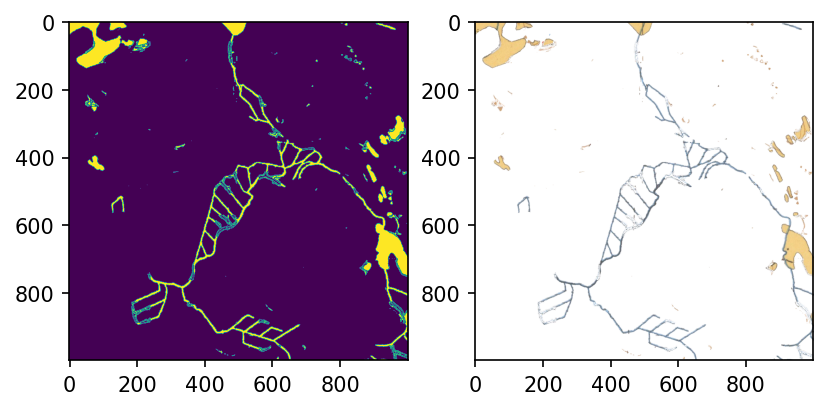

In [ ]:
fields = np.empty(data.shape)
fields[data==1] = 1
fields[data==4] = 1
fields = fields[2500:3500, 2000:3000]
fields = fields.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[2500:3500, 2000:3000,:].copy()
tempmap[fields != 1] = 255
axs[0].imshow(fields)
axs[1].imshow(tempmap)

Example postprocessing chain looks like this.

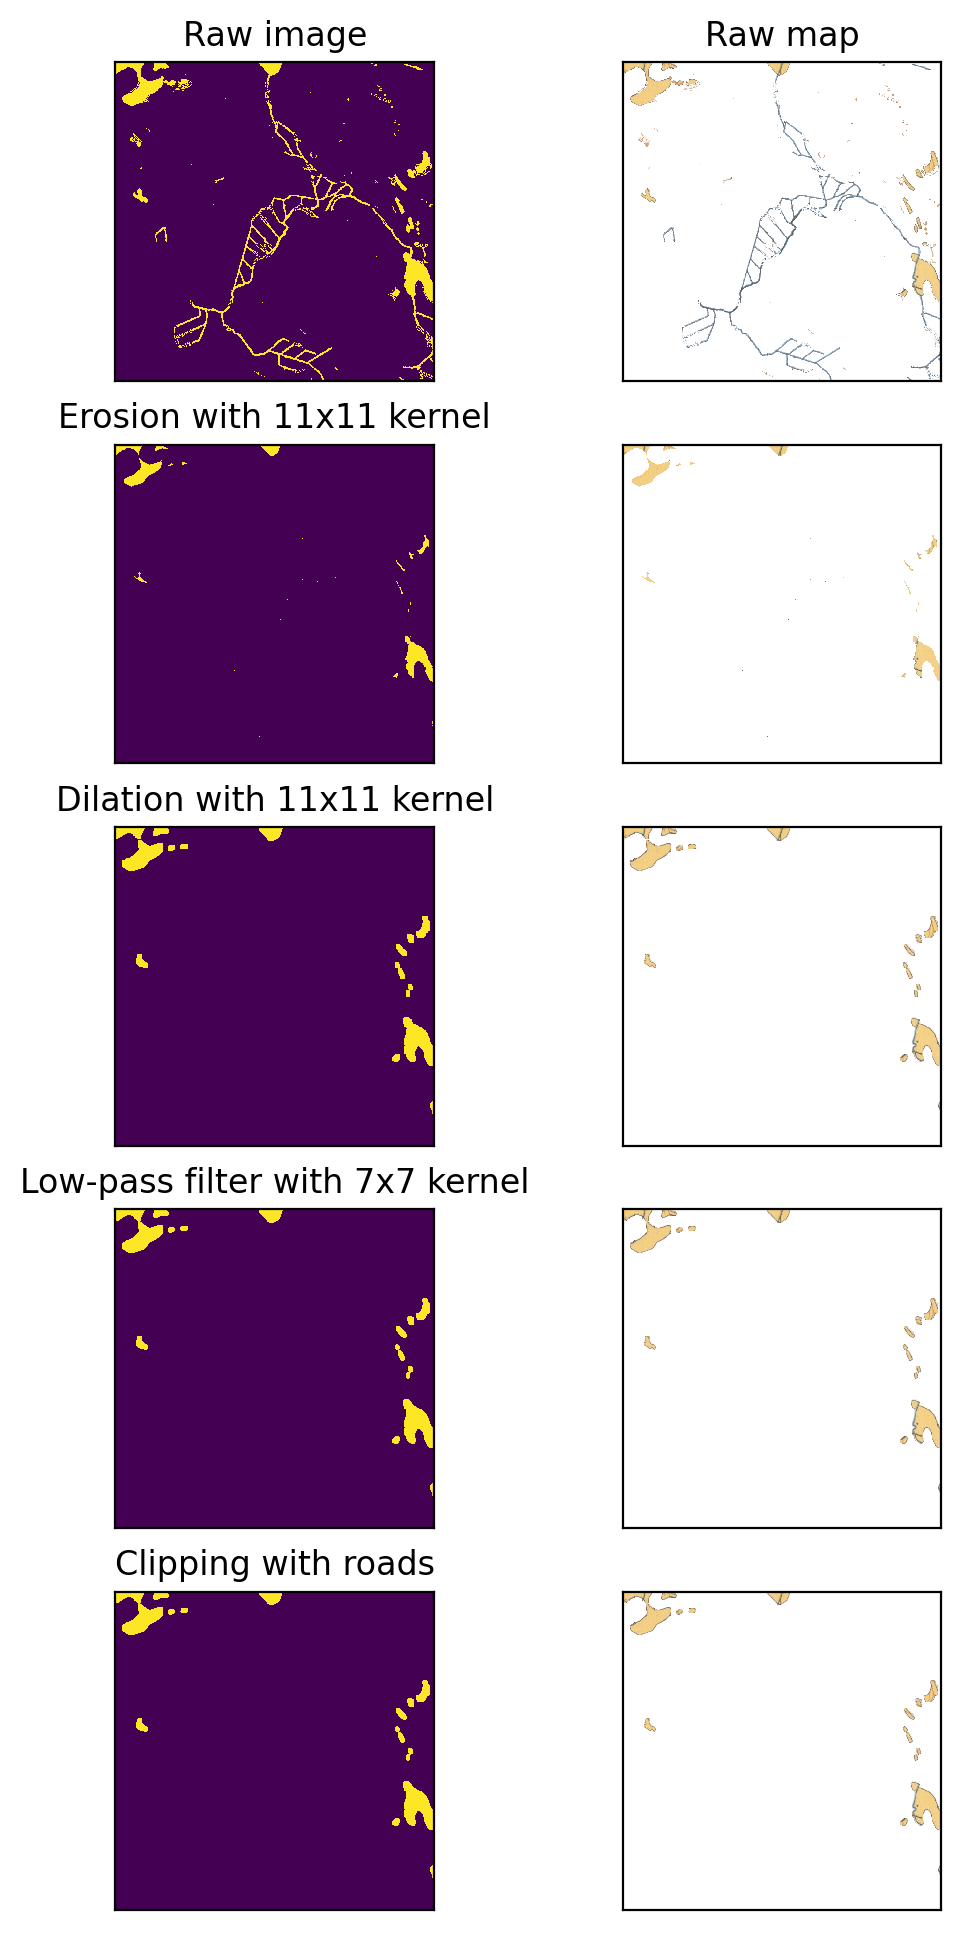

In [ ]:
fig, axs = plt.subplots(5,2, dpi=200, figsize=(6,12))
for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])
    
axs[0,0].imshow(fields, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
open_ex = cv2.erode(fields, er_kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Erosion with 11x11 kernel')

temp_open = mapdata[2500:3500, 2000:3000,:].copy()
temp_open[open_ex != 1] = 255
axs[1,1].imshow(temp_open, interpolation='none')

open_ex = cv2.morphologyEx(open_ex, cv2.MORPH_OPEN, np.ones((3,3)))
open_ex = cv2.dilate(open_ex, dil_kernel)
axs[2,0].imshow(open_ex, interpolation='none')
axs[2,0].set_title('Dilation with 11x11 kernel')

temp_open = mapdata[2500:3500, 2000:3000,:].copy()
temp_open[open_ex != 1] = 255
axs[2,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[3,0].imshow(lpf_ex, interpolation='none')
axs[3,0].set_title('Low-pass filter with 7x7 kernel')

temp_lpf = mapdata[2500:3500, 2000:3000,:].copy()
temp_lpf[lpf_ex != 1] = 255

axs[3,1].imshow(temp_lpf, interpolation='none')

roadclip = lpf_ex.copy()
roadclip[data[2500:3500, 2000:3000] == 3] = 0

axs[4,0].imshow(roadclip, interpolation='none')
axs[4,0].set_title('Clipping with roads')

temp_lpf[data[2500:3500, 2000:3000] == 3] = 255

axs[4,1].imshow(temp_lpf, interpolation='none')

plt.savefig('../data/figures/field_postproc.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Mires

Similar to fields, watercourses running through mires do not split mires into multiple sections.

<matplotlib.image.AxesImage>

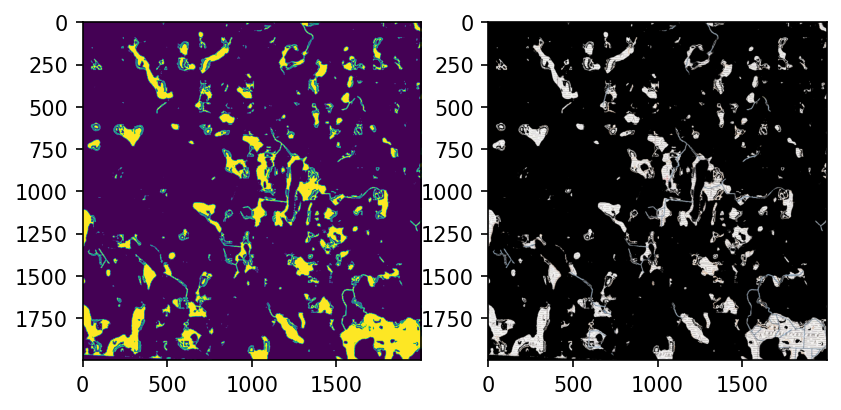

In [ ]:
mires = np.empty(data.shape)
mires[data==2] = 1
mires[data==4] = 1
mires = mires[4000:6000, 2000:4000]
mires = mires.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[4000:6000, 2000:4000,:].copy()
tempmap[mires != 1] = 0
axs[0].imshow(mires)
axs[1].imshow(tempmap)

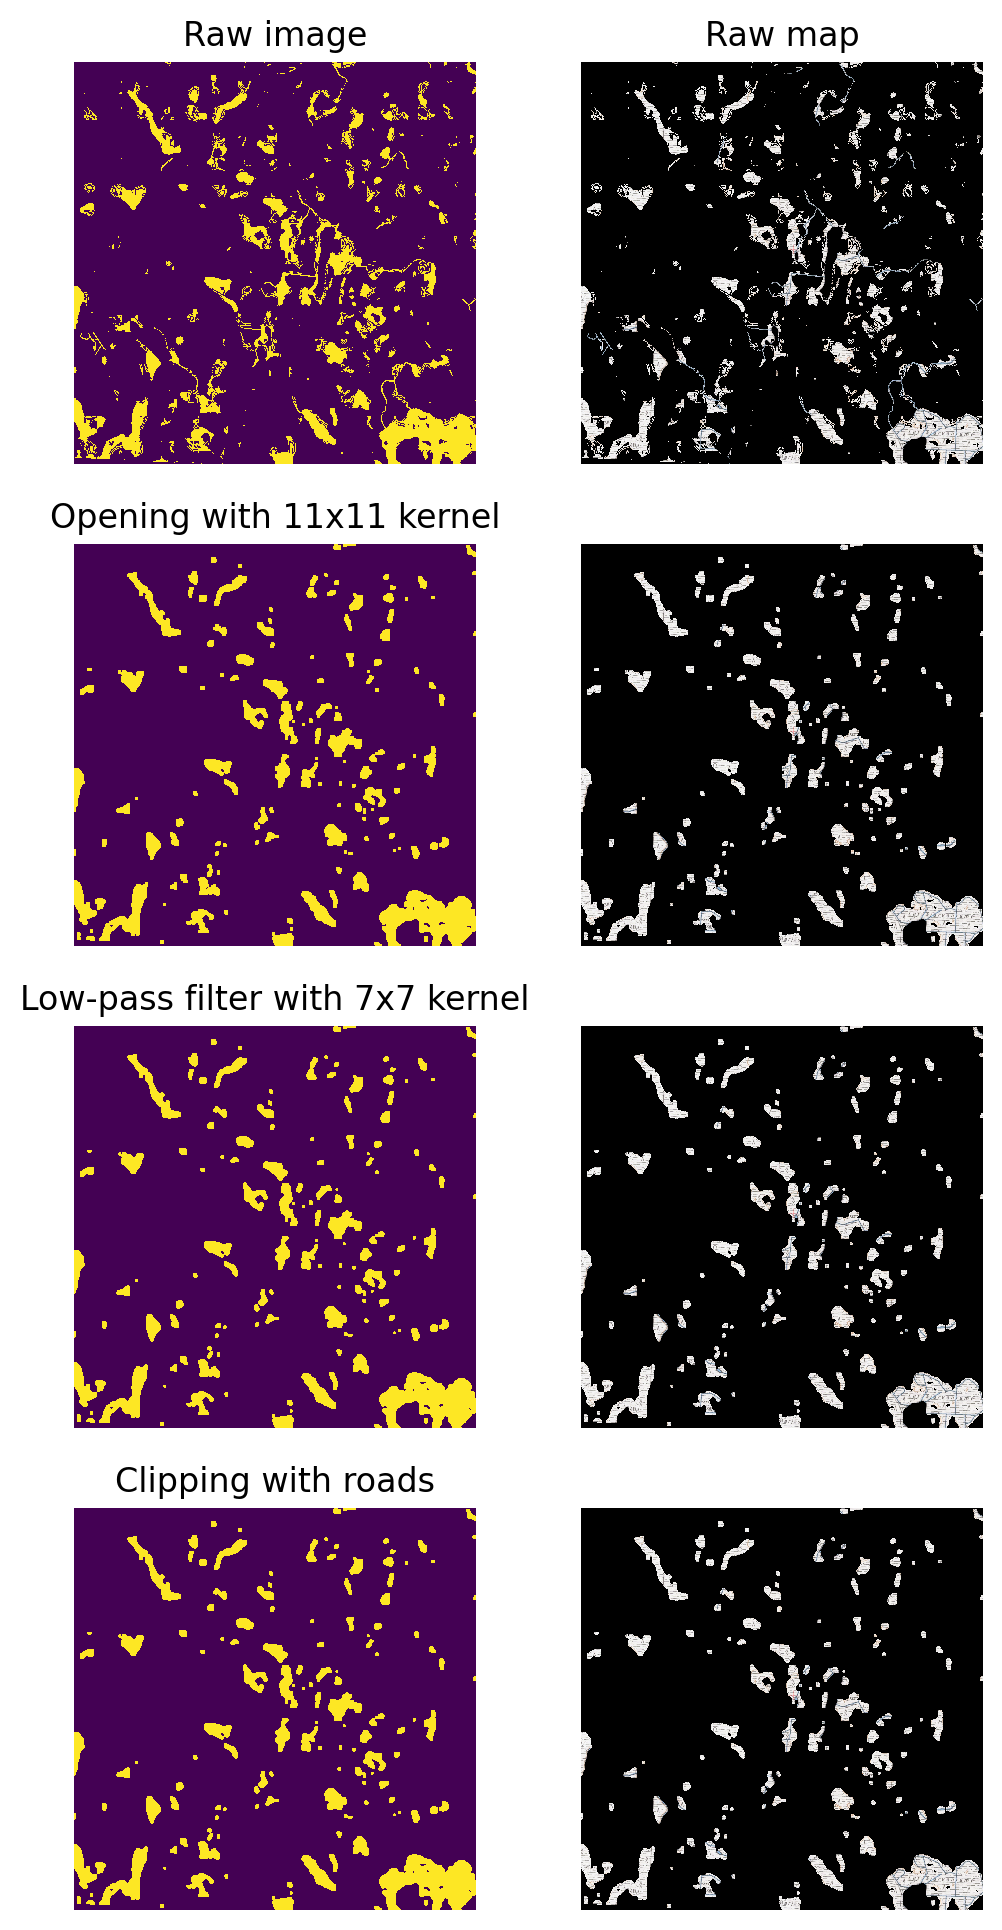

In [ ]:
fig, axs = plt.subplots(4,2, dpi=200, figsize=(6,12))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(mires, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (13,13))
dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
open_ex = cv2.erode(mires, er_kernel)
open_ex = cv2.morphologyEx(open_ex, cv2.MORPH_OPEN, np.ones((3,3)))
open_ex = cv2.dilate(open_ex, dil_kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Opening with 11x11 kernel')

temp_open =  mapdata[4000:6000, 2000:4000,:].copy()
temp_open[open_ex == 0] = 0

axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 7x7 kernel')

temp_lpf =  mapdata[4000:6000, 2000:4000,:].copy()
temp_lpf[lpf_ex == 0] = 0

axs[2,1].imshow(temp_lpf, interpolation='none')

roadclip = lpf_ex.copy()
roadclip[data[4000:6000, 2000:4000] == 3] = 0

axs[3,0].imshow(roadclip, interpolation='none')
axs[3,0].set_title('Clipping with roads')

temp_lpf[data[4000:6000, 2000:4000] == 3] = 255

axs[3,1].imshow(temp_lpf, interpolation='none')

plt.show()

## Roads

Roads are postprocessed with `MORPH.CLOSE` (dilation followed by erosion), LPF and erosion.

<matplotlib.image.AxesImage>

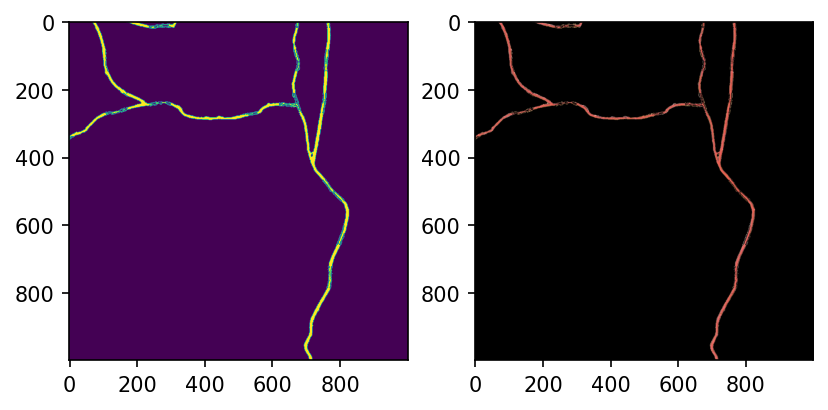

In [ ]:
roads = np.empty(data.shape)
roads[data==3] = 1
roads = roads[300:1300, 4500:5500]
roads = roads.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[300:1300, 4500:5500,:].copy()
tempmap[roads != 1] = 0
axs[0].imshow(roads)
axs[1].imshow(tempmap)

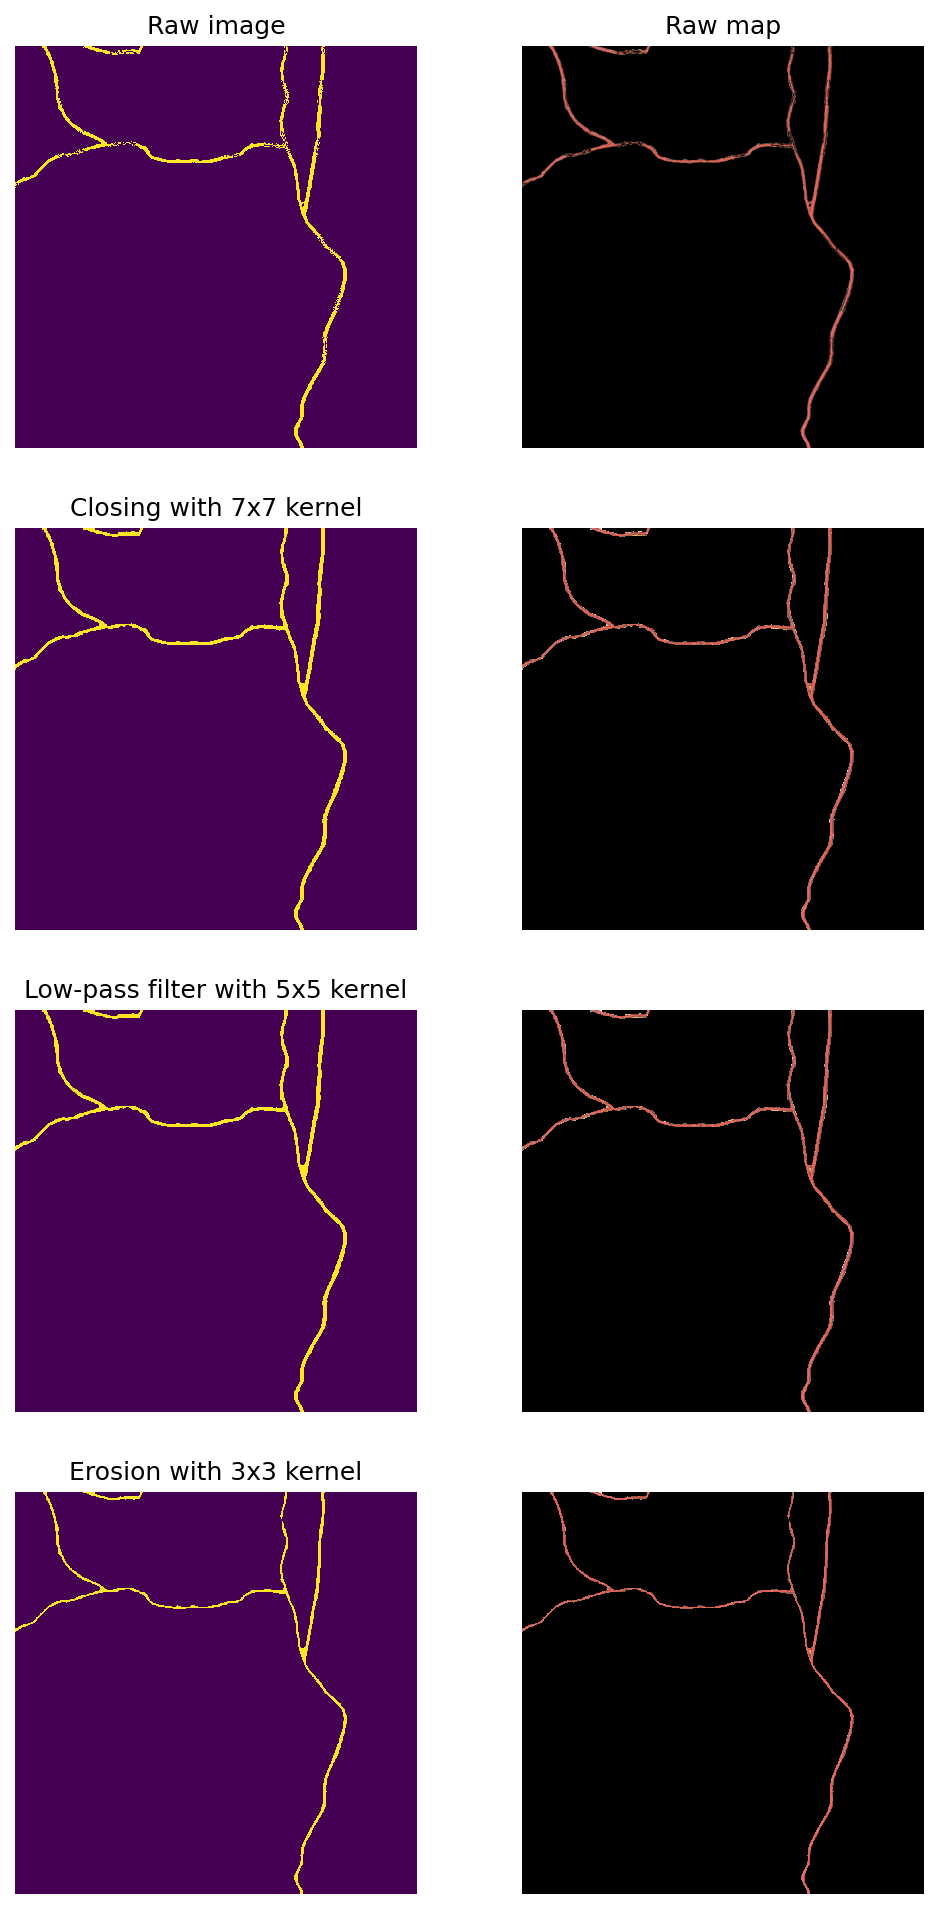

In [ ]:
fig, axs = plt.subplots(4,2, dpi=150, figsize=(8,16))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(roads, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap)

kernel = np.ones((7,7), np.uint8)
open_ex = cv2.morphologyEx(roads, cv2.MORPH_CLOSE, kernel)
temp_open = mapdata[300:1300, 4500:5500,:].copy()
temp_open[open_ex != 1] = 0
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Closing with 7x7 kernel')
axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((5,5), np.float32)/25
lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)
temp_lpf = temp_open.copy()
temp_lpf[lpf_ex == 0] = 0
axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 5x5 kernel')
axs[2,1].imshow(temp_lpf, interpolation='none')

eroded = cv2.erode(lpf_ex, np.ones((3,3), np.uint8), iterations=1)
temp_er = mapdata[300:1300, 4500:5500,:].copy()
temp_er[eroded != 1] = 0
axs[3,0].imshow(eroded, interpolation='none')
axs[3,0].set_title('Erosion with 3x3 kernel')
axs[3,1].imshow(temp_er, interpolation='none')

plt.show()

Next step is to skeletonize roads in order to generate line geometries from them.

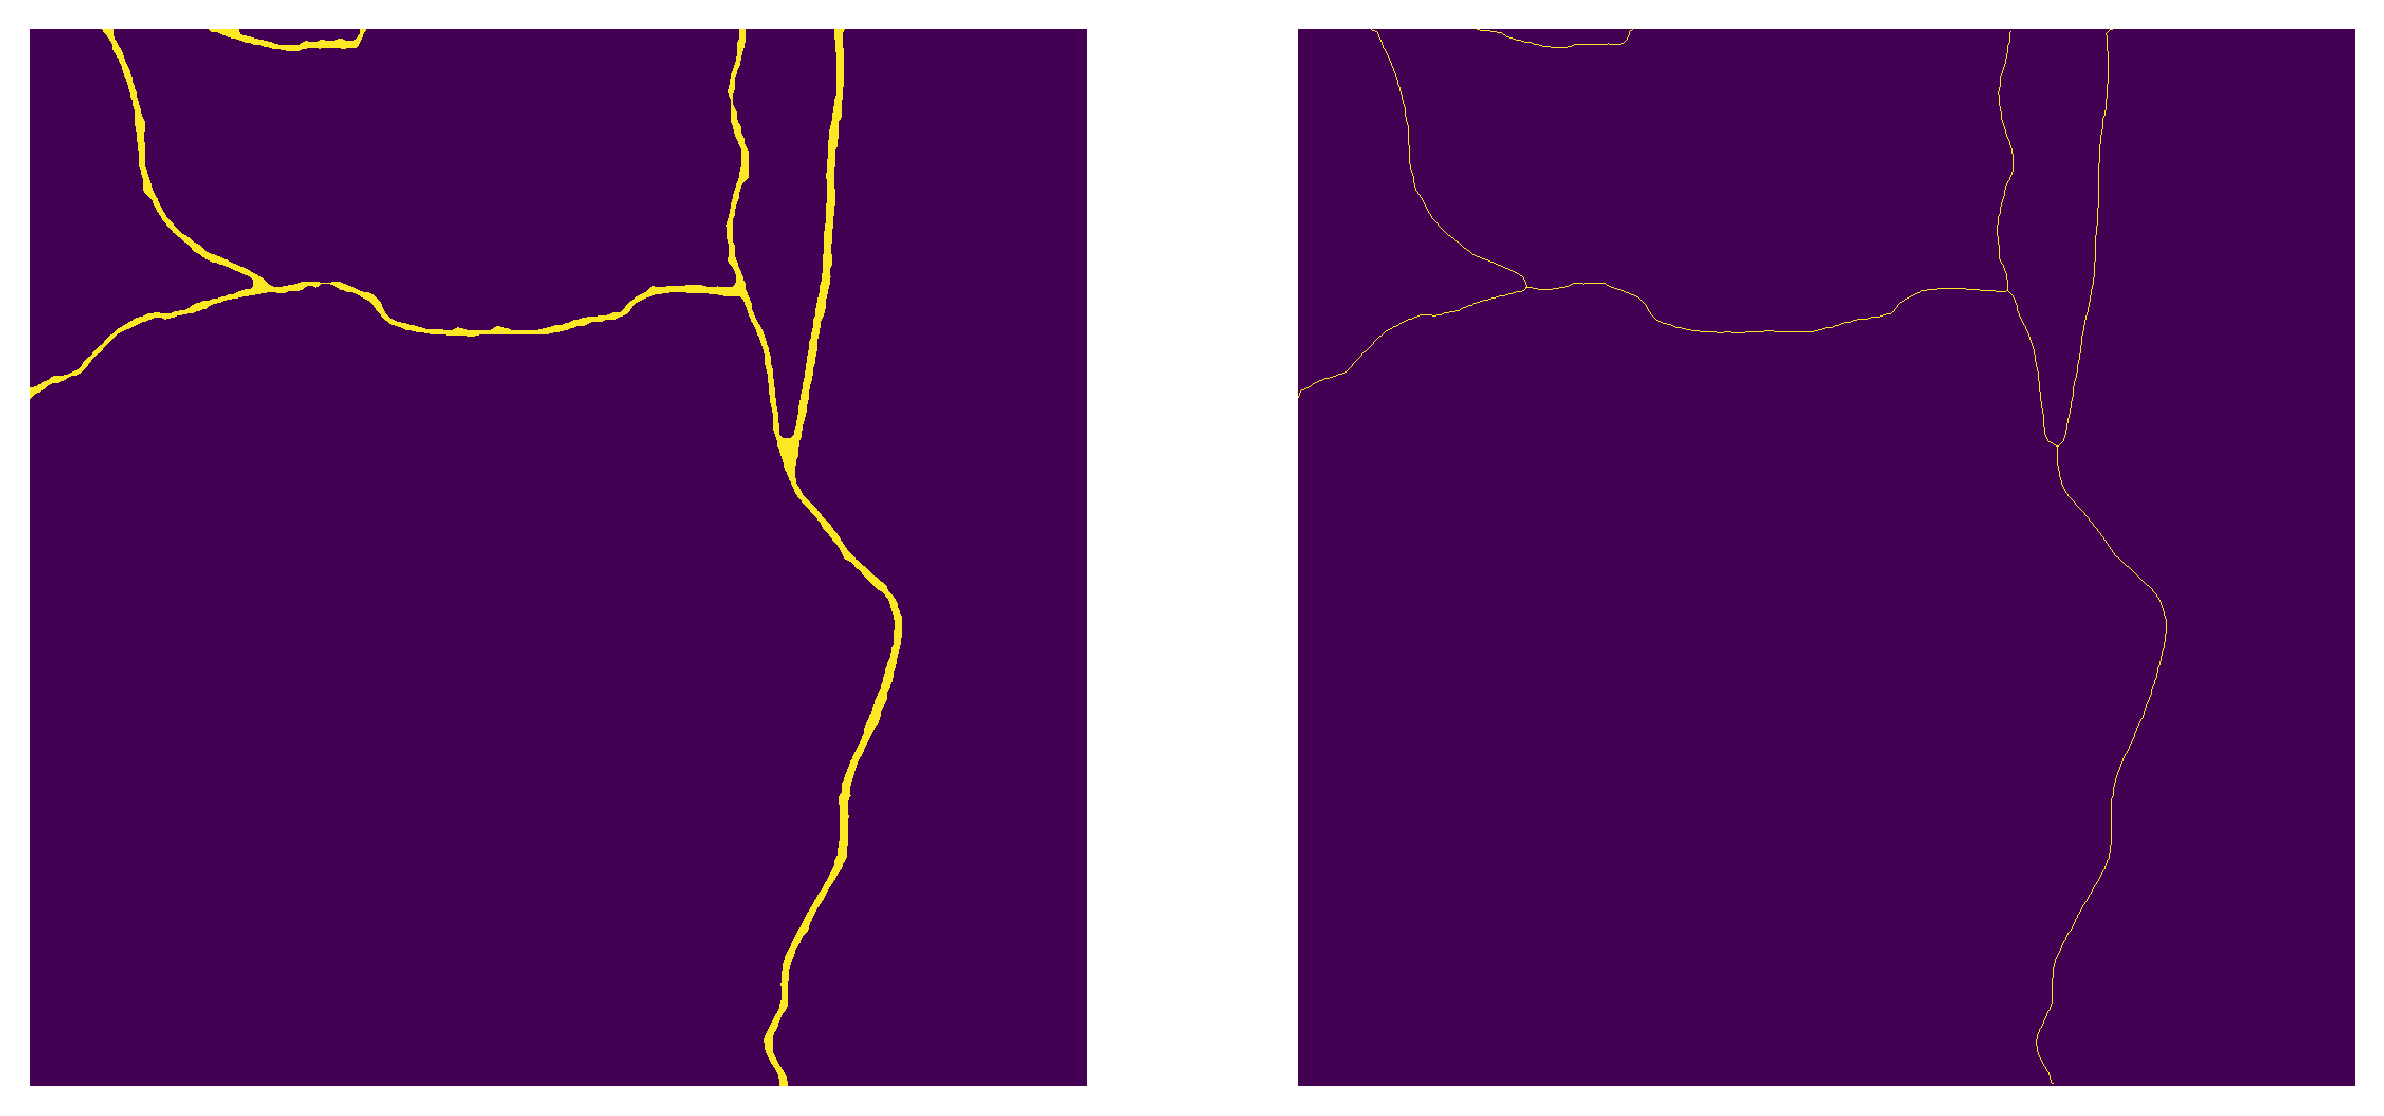

In [ ]:
skeletonized = skeletonize(eroded)

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300)
for a in axs: a.axis('off')

axs[0].imshow(eroded, interpolation='none')
axs[1].imshow(skeletonized, interpolation='none')
plt.show()

These are then polygonized and merged into polygon data, that can then be used to get line geometries.

## Watercourses

<matplotlib.image.AxesImage>

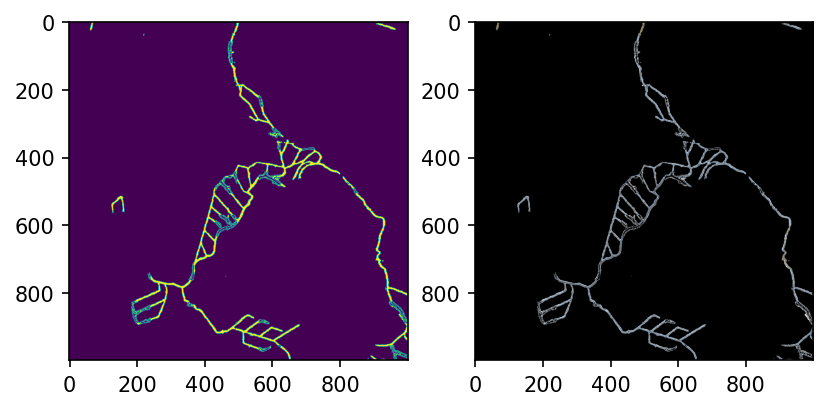

In [ ]:
watercourses = np.empty(data.shape)
watercourses[data==4] = 1
watercourses = watercourses[2500:3500,2000:3000]
watercourses = watercourses.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[2500:3500, 2000:3000,:].copy()
tempmap[watercourses != 1] = 0
axs[0].imshow(watercourses)
axs[1].imshow(tempmap)

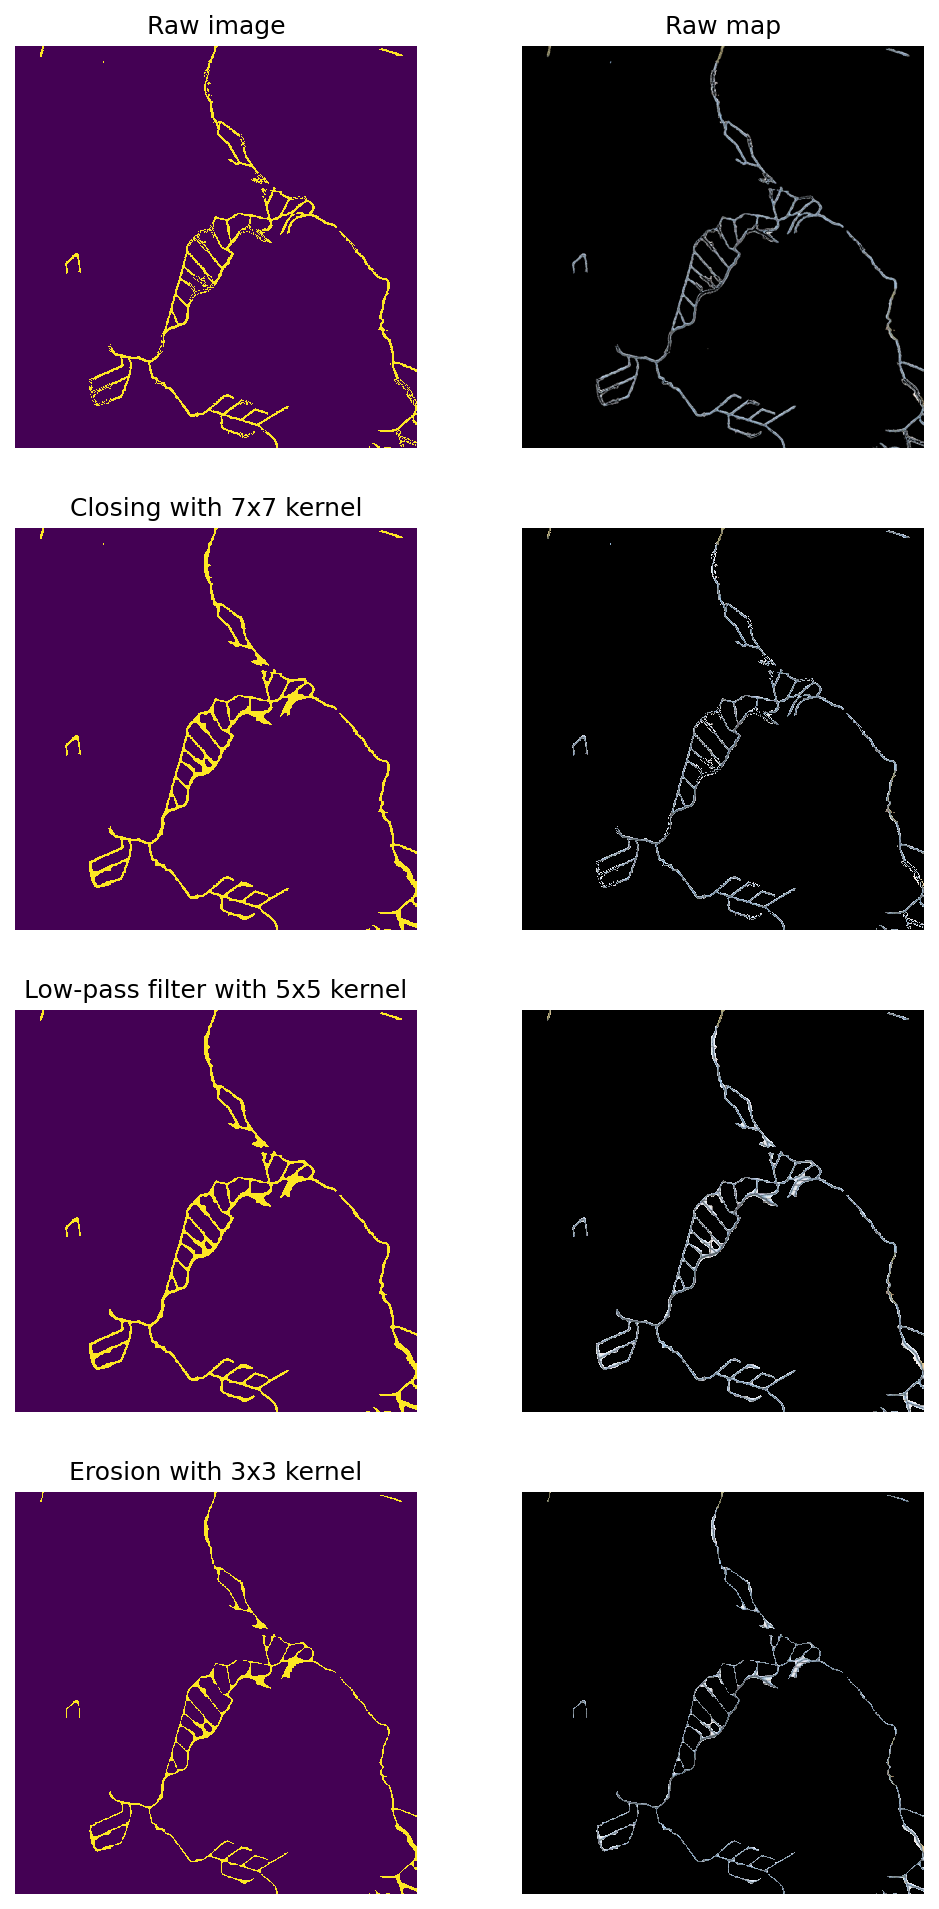

In [ ]:
fig, axs = plt.subplots(4,2, dpi=150, figsize=(8,16))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(watercourses, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap)

kernel = np.ones((7,7), np.uint8)
open_ex = cv2.morphologyEx(watercourses, cv2.MORPH_CLOSE, kernel)
temp_open = tempmap.copy()
temp_open[open_ex != 1] = 0
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Closing with 7x7 kernel')
axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((5,5), np.float32)/25
lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)
temp_lpf =  mapdata[2500:3500, 2000:3000,:].copy()
temp_lpf[lpf_ex == 0] = 0
axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 5x5 kernel')
axs[2,1].imshow(temp_lpf, interpolation='none')

eroded = cv2.erode(lpf_ex, np.ones((3,3), np.uint8), iterations=1)
temp_er = mapdata[2500:3500, 2000:3000,:].copy()
temp_er[eroded != 1] = 0
axs[3,0].imshow(eroded, interpolation='none')
axs[3,0].set_title('Erosion with 3x3 kernel')
axs[3,1].imshow(temp_er, interpolation='none')

plt.show()

Visually compare the different skeletonizing methods: `skimage.morphology.skeletonize`, `skimage.morphology.thin` and `skimage.morphology.medial_axis`.

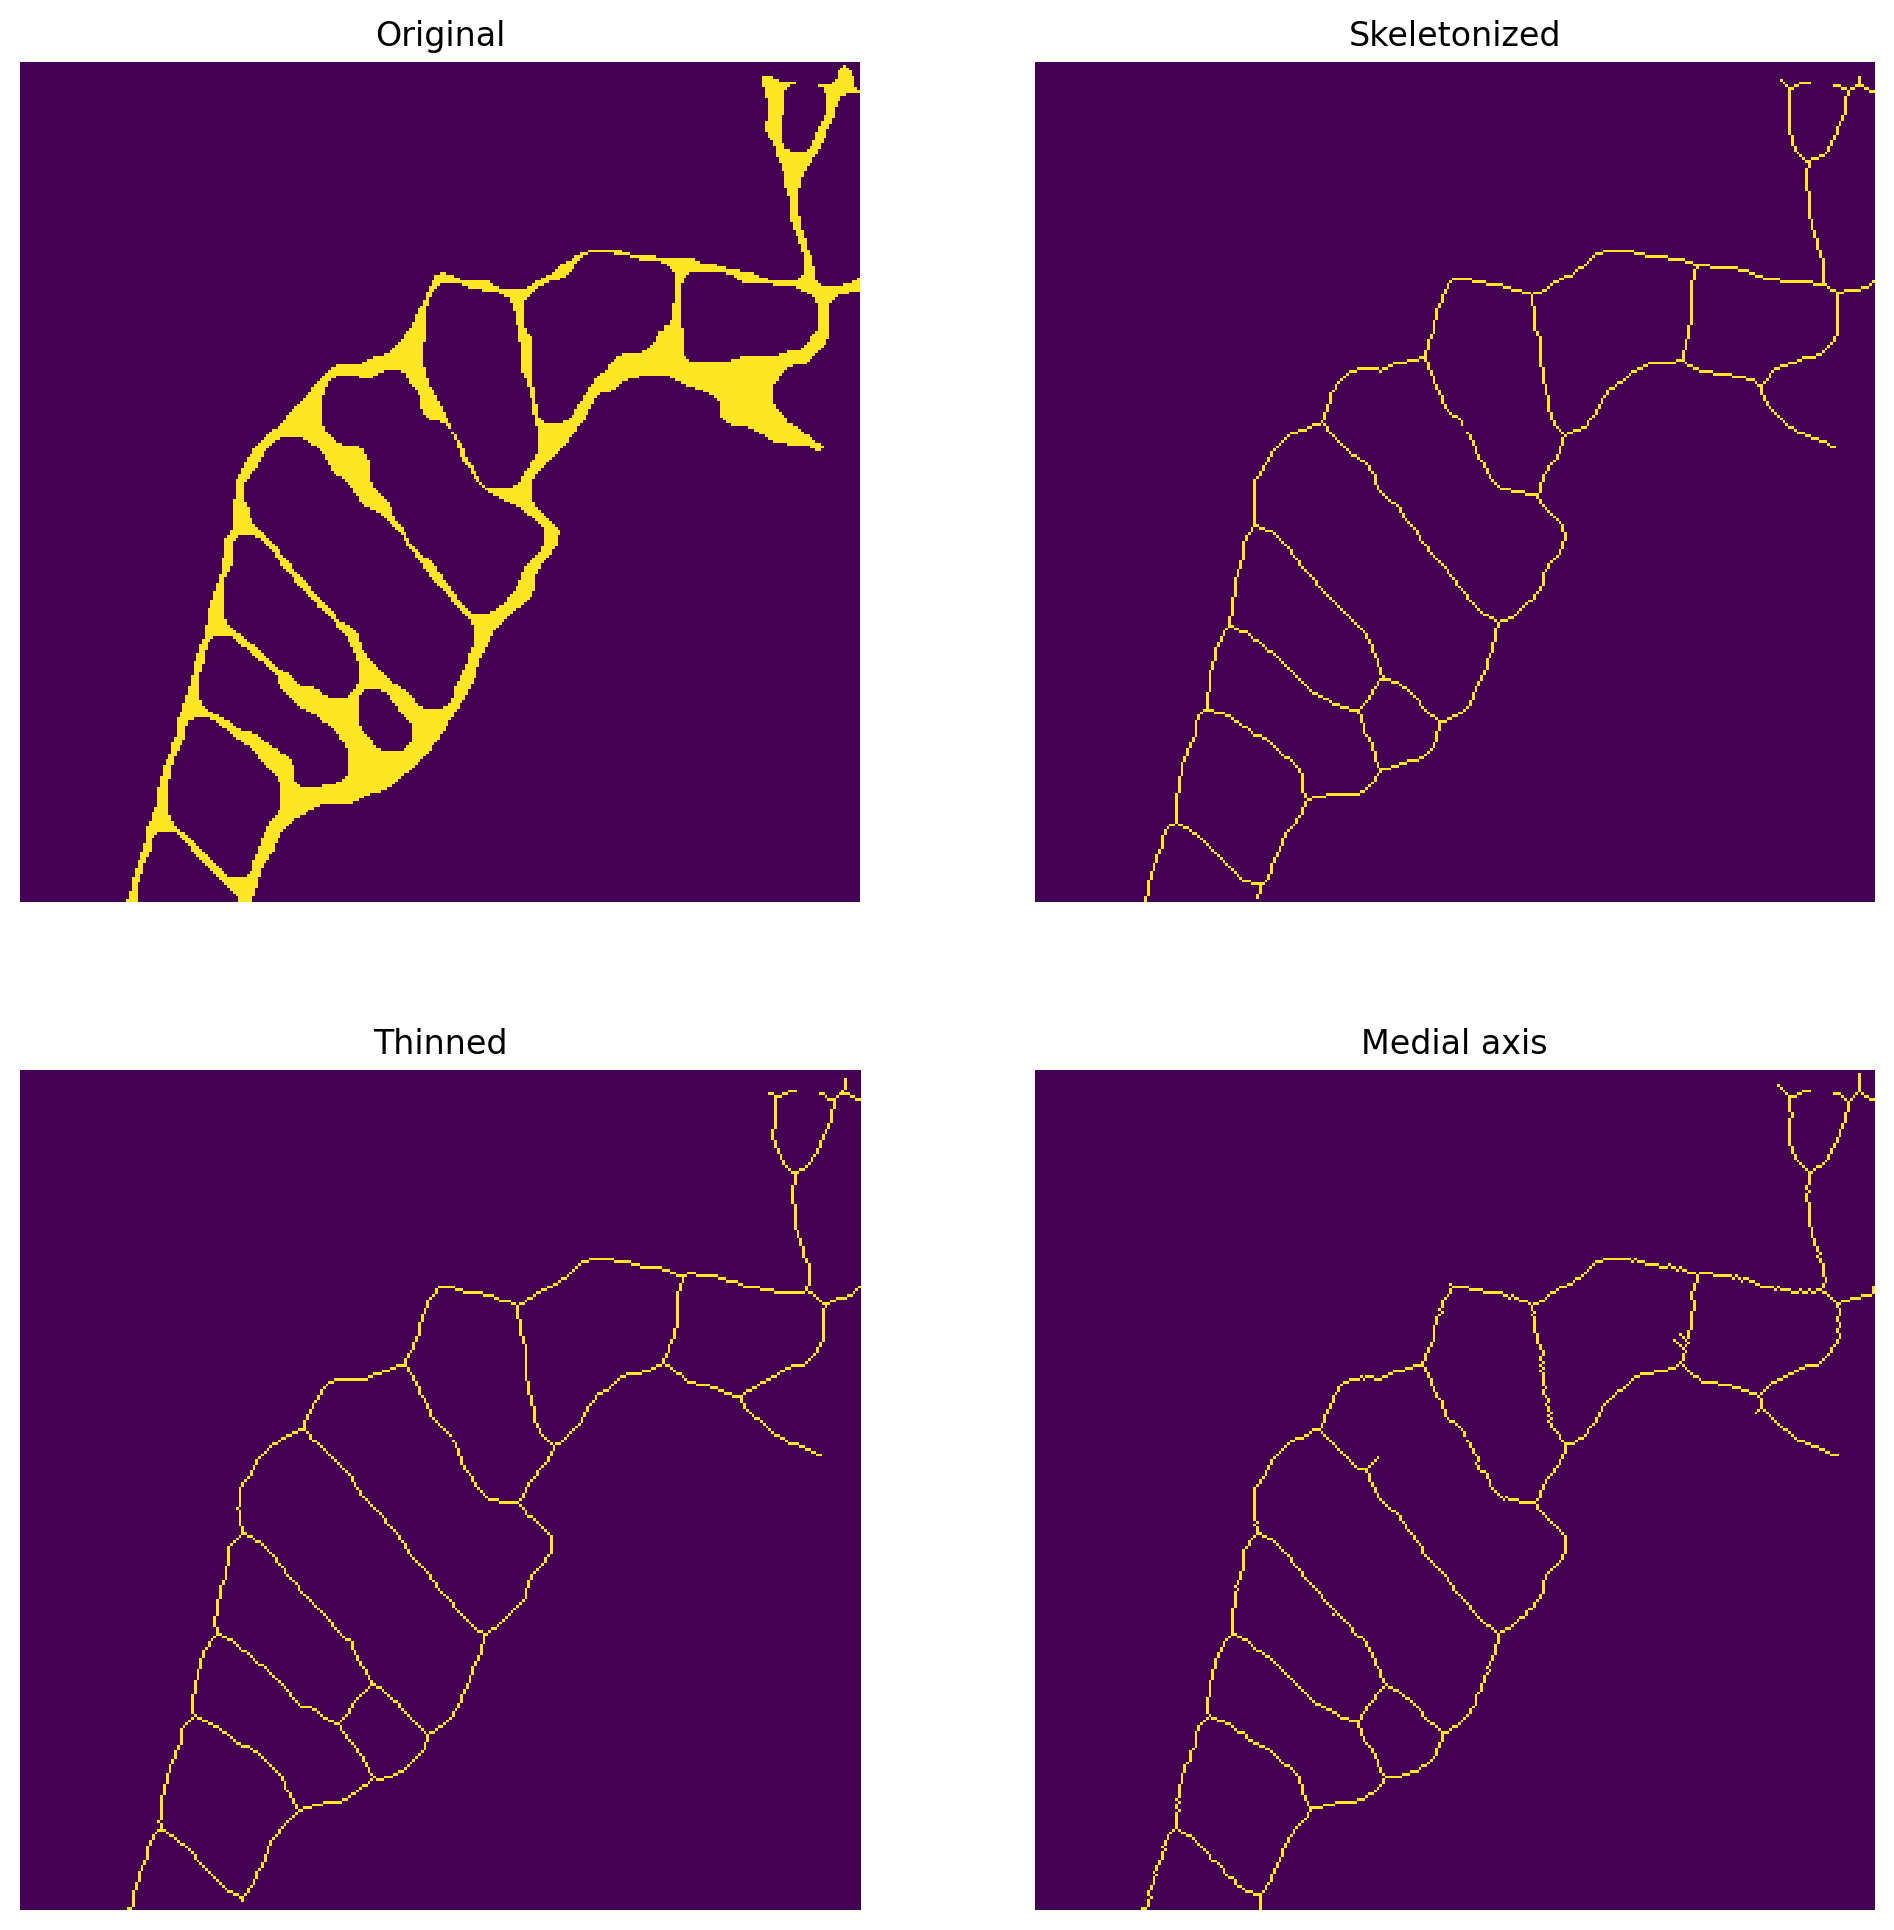

In [ ]:
skeletonized = skeletonize(eroded[350:-350, 350:-350])
thinned = thin(eroded[350:-350, 350:-350])
med_axis = medial_axis(eroded[350:-350, 350:-350])

fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=200)
for a in axs.flatten(): a.axis('off')

axs[0,0].imshow(eroded[350:-350, 350:-350], interpolation='none')
axs[0,0].set_title('Original')
axs[0,1].imshow(skeletonized, interpolation='none')
axs[0,1].set_title('Skeletonized')
axs[1,0].imshow(thinned, interpolation='none')
axs[1,0].set_title('Thinned')
axs[1,1].imshow(med_axis, interpolation='none')
axs[1,1].set_title('Medial axis')
plt.show()

Seems that no major differences between the methods,

## Water bodies

<matplotlib.image.AxesImage>

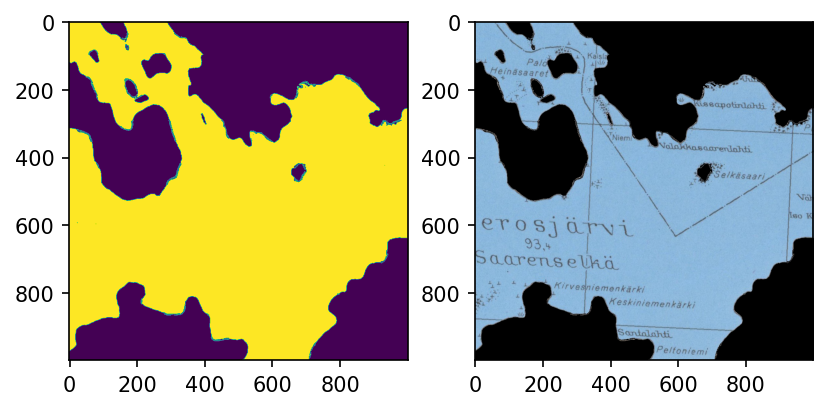

In [ ]:
waterbodies = np.empty(data.shape)
waterbodies[data==5] = 1
waterbodies = waterbodies[1500:2500, 1000:2000]
waterbodies = waterbodies.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[1500:2500, 1000:2000,:].copy()
tempmap[waterbodies != 1] = 0
axs[0].imshow(waterbodies)
axs[1].imshow(tempmap)

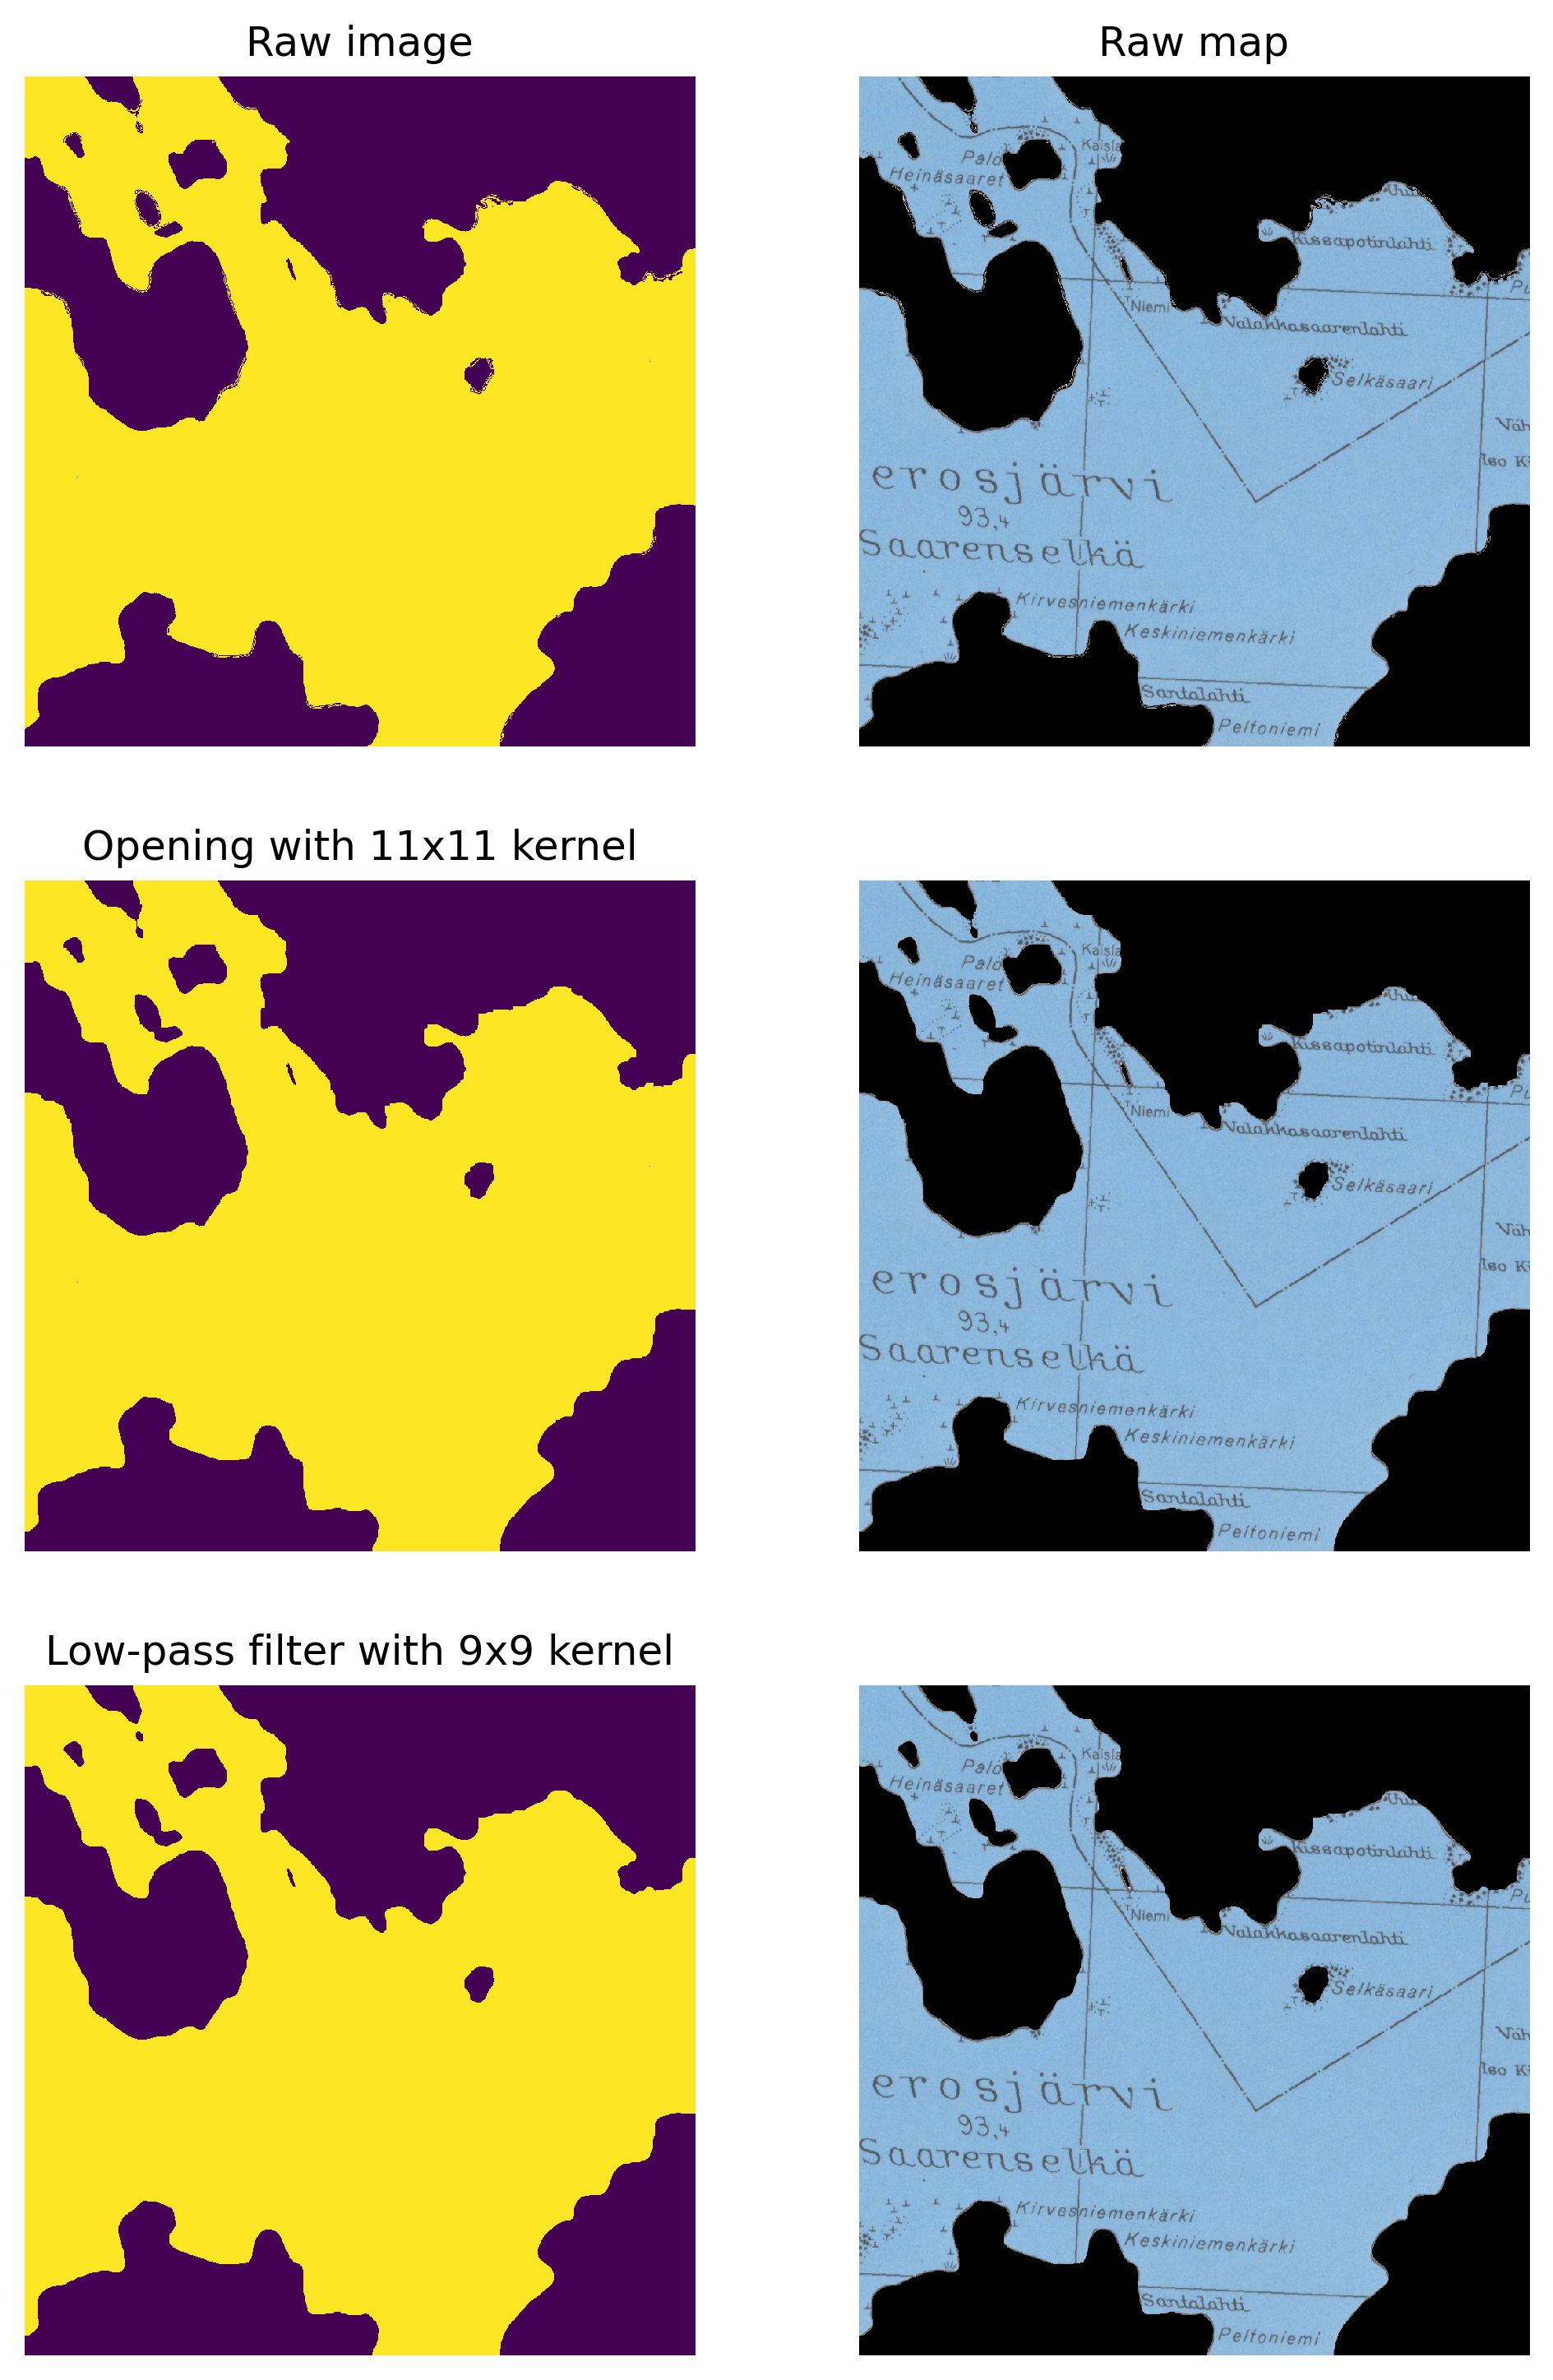

In [ ]:
fig, axs = plt.subplots(3,2, dpi=300, figsize=(8,12))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(waterbodies, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
kernel = np.ones((11,11), np.uint8)
open_ex = cv2.morphologyEx(waterbodies, cv2.MORPH_OPEN, kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Opening with 11x11 kernel')

temp_open = mapdata[1500:2500, 1000:2000,:].copy()
temp_open[open_ex == 0] = 0

axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 9x9 kernel')

temp_lpf = mapdata[1500:2500, 1000:2000,:].copy()
temp_lpf[lpf_ex == 0] = 0

axs[2,1].imshow(temp_lpf, interpolation='none')

plt.show()

## All together:

In [ ]:
def run_postproc_chain(inpath, outpath):
    with rio.open(inpath) as src:
        data = src.read()[0]
        prof = src.profile
    fields = np.where((data==1) | (data==4), 1, 0).astype(np.uint8)
    mires = np.where((data==2) | (data==4), 1, 0).astype(np.uint8)
    roads = np.where(data==3, 1, 0).astype(np.uint8)
    watercourses = np.where(data==4, 1, 0).astype(np.uint8)
    waterbodies = np.where(data==5, 1, 0).astype(np.uint8)
    
    er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
    
    fields = cv2.erode(fields, er_kernel)
    fields = cv2.morphologyEx(fields, cv2.MORPH_OPEN, np.ones((3,3)))
    fields = cv2.dilate(fields, dil_kernel)
    fields = cv2.filter2D(fields, -1,  np.ones((7,7), np.float32)/49)

    mires = cv2.erode(mires, er_kernel)
    mires = cv2.morphologyEx(mires, cv2.MORPH_OPEN, np.ones((3,3)))
    mires = cv2.dilate(mires, dil_kernel)    
    mires = cv2.filter2D(mires, -1,  np.ones((7,7), np.float32)/49)
    
    roads = cv2.morphologyEx(roads, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    roads = cv2.filter2D(roads, -1, np.ones((5,5), np.float32)/25)

    watercourses = cv2.morphologyEx(watercourses, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    watercourses = cv2.filter2D(watercourses, -1, np.ones((5,5), np.float32)/25)
    
    waterbodies = cv2.morphologyEx(waterbodies, cv2.MORPH_OPEN, np.ones((11,11), np.uint8))
    waterbodies = cv2.filter2D(waterbodies, -1,  np.ones((7,7), np.float32)/49)
    
    prof.update({'count': 5})
    
    # Roads split these classes into multiple geometries
    fields[roads == 1] = 0
    mires[roads == 1] = 0
    # Clip with waterbodies also
    fields[waterbodies == 1] = 0
    mires[waterbodies == 1] = 0
    
    with rio.open(outpath, 'w', **prof) as dest:
        dest.write(fields, 1)
        dest.write(mires, 2)
        dest.write(roads, 3)
        dest.write(watercourses, 4)
        dest.write(waterbodies, 5)

In [ ]:
from tqdm import tqdm
from pathlib import Path
import os

indir = Path('../results/raw/')
outdir = Path('../results/processed/')
for f in tqdm(os.listdir(indir)):
    run_postproc_chain(indir/f, outdir/f)

val_indir = Path('../data/reference_masks/')
val_outdir = Path('../data/reference_masks/postproc')
for f in tqdm(['val_mask_1965.tif', 'val_mask_1984.tif']):
    run_postproc_chain(val_indir/f, val_outdir/f)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


# Evaluating post-processed test set

In [ ]:
with rio.open('../results/processed/213405_1965.tif') as pred_src:
    bounds_test = pred_src.bounds
    preds_65_proc_raw, tfm_65 = rio_mask.mask(pred_src, [box(*bounds_test).intersection(box(*bounds_65))], crop=True)

preds_65_proc = np.zeros((preds_65_proc_raw.shape[1], preds_65_proc_raw.shape[2]))
preds_65_proc[preds_65_proc_raw[0] == 1] = 1
preds_65_proc[preds_65_proc_raw[1] == 1] = 2
preds_65_proc[preds_65_proc_raw[2] == 1] = 3
preds_65_proc[preds_65_proc_raw[3] == 1] = 4
preds_65_proc[preds_65_proc_raw[4] == 1] = 5

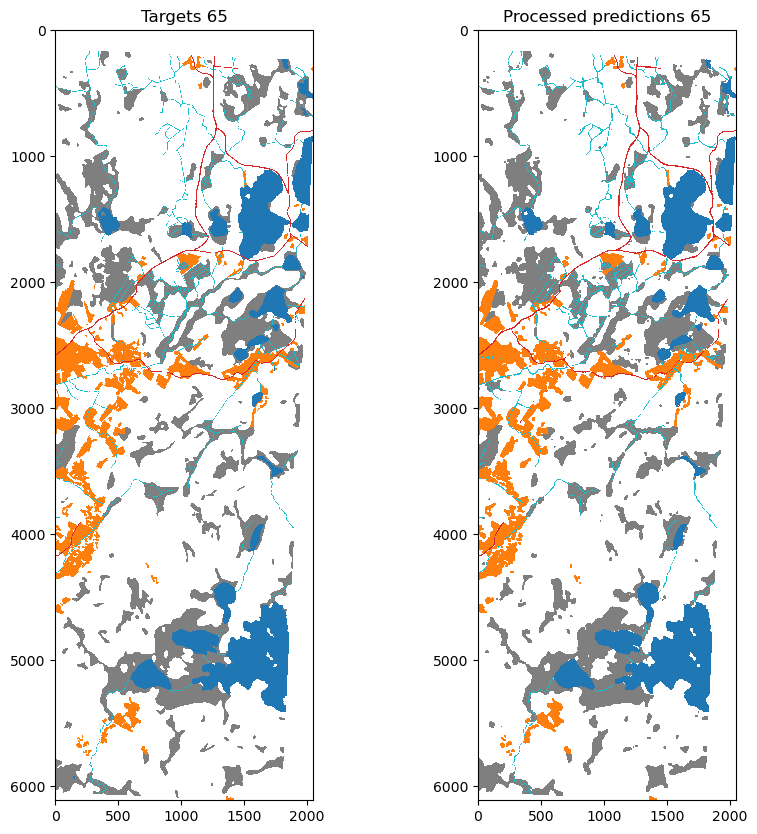

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'tab:orange', 'tab:grey', 'tab:red', 'tab:cyan', 'tab:blue'])
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(test_mask_65, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[0].set_title('Targets 65')
axs[1].imshow(preds_65_proc, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[1].set_title('Processed predictions 65')
plt.show()

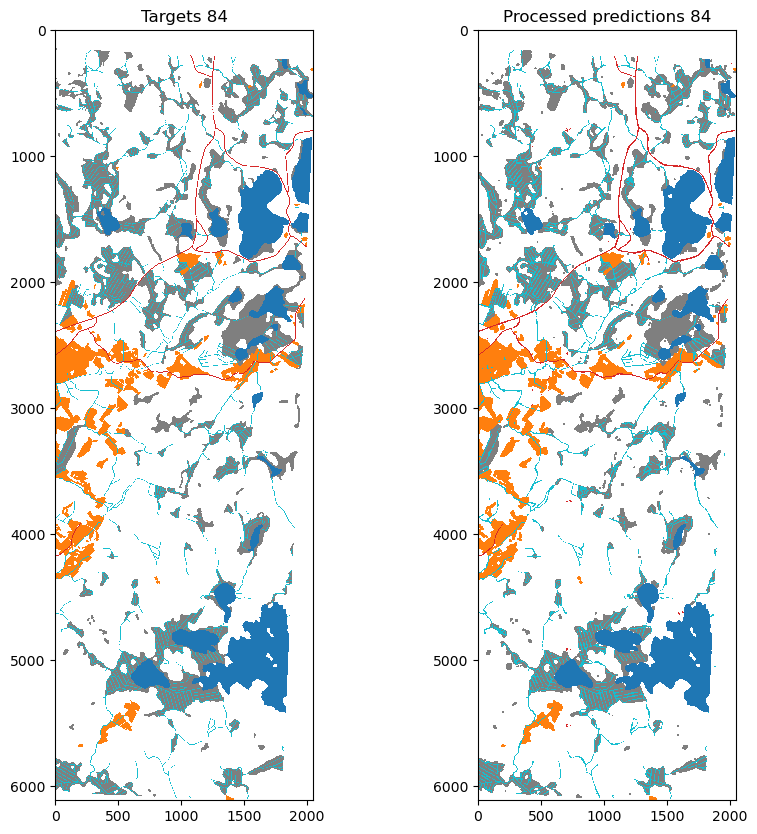

In [ ]:
with rio.open('../results/processed/213405_1984.tif') as pred_src:
    bounds_test = pred_src.bounds
    preds_84_proc_raw, tfm_84 = rio_mask.mask(pred_src, [box(*bounds_test).intersection(box(*bounds_84))], crop=True)


preds_84_proc = np.zeros((preds_84_proc_raw.shape[1], preds_84_proc_raw.shape[2]))
preds_84_proc[preds_84_proc_raw[0] == 1] = 1
preds_84_proc[preds_84_proc_raw[1] == 1] = 2
preds_84_proc[preds_84_proc_raw[2] == 1] = 3
preds_84_proc[preds_84_proc_raw[3] == 1] = 4
preds_84_proc[preds_84_proc_raw[4] == 1] = 5

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(test_mask_84, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[0].set_title('Targets 84')
axs[1].imshow(preds_84_proc, vmin=0, vmax=5, cmap=cmap, interpolation='none')
axs[1].set_title('Processed predictions 84')
plt.show()

Evaluate post-processed predictions.

In [ ]:
classes = ['Fields', 'Mires', 'Roads', 'Watercourses', 'Water bodies']

dices_65 = []
dices_84 = []
ious_65 = []
ious_84 = []
pres_65 = []
pres_84 = []
recs_65 = []
recs_84 = []


for c in range(0,5):
    dice_65 = dice(test_mask_65, preds_65_proc, c+1)
    dice_84 = dice(test_mask_84, preds_84_proc, c+1)
    dices_65.append(dice_65)
    dices_84.append(dice_84)
    
    iou_65 = jaccard(test_mask_65, preds_65_proc, c+1)
    iou_84 = jaccard(test_mask_84, preds_84_proc, c+1)
    ious_65.append(iou_65)
    ious_84.append(iou_84)
    
    pre_65 = pre(test_mask_65, preds_65_proc, c+1)
    pre_84 = pre(test_mask_84, preds_84_proc, c+1)
    pres_65.append(pre_65)
    pres_84.append(pre_84)
    
    rec_65 = rec(test_mask_65, preds_65_proc, c+1)
    rec_84 = rec(test_mask_84, preds_84_proc, c+1)
    recs_65.append(rec_65)
    recs_84.append(rec_84)
    
    print(f'Results for class {classes[c]}:')
    print(f'Dice: 65 map: {dice_65:.3f}, 84 map: {dice_84:.3f}, overall {(dice_65+dice_84)/2:.3f}')
    print(f'Jaccard: 65 map: {iou_65:.3f}, 84 map: {iou_84:.3f}, overall {(iou_65+iou_84)/2:.3f}')
    print(f'Precision: 65 map: {pre_65:.3f}, 84 map: {pre_84:.3f}, overall {(pre_65+pre_84)/2:.3f}')
    print(f'Recall: 65 map: {rec_65:.3f}, 84 map: {rec_84:.3f}, overall {(rec_65+rec_84)/2:.3f}\n')    
    
print(f'Overall results:')
print(f'Dice: 65 map: {sum(dices_65)/5:.3f}, 84 map: {sum(dices_84)/5:.3f}, overall {(sum(dices_65)+sum(dices_84))/10:.3f}')
print(f'Jaccard: 65 map: {sum(ious_65)/5:.3f}, 84 map: {sum(ious_84)/5:.3f}, overall {(sum(ious_65)+sum(ious_84))/10:.3f}')
print(f'Precision: 65 map: {sum(pres_65)/5:.3f}, 84 map: {sum(pres_84)/5:.3f}, overall {(sum(pres_65)+sum(pres_84))/10:.3f}')
print(f'Recall: 65 map: {sum(recs_65)/5:.3f}, 84 map: {sum(recs_84)/5:.3f}, overall {(sum(recs_65)+sum(recs_84))/10:.3f}')

Results for class Fields:
Dice: 65 map: 0.931, 84 map: 0.934, overall 0.933
Jaccard: 65 map: 0.872, 84 map: 0.876, overall 0.874
Precision: 65 map: 0.909, 84 map: 0.914, overall 0.912
Recall: 65 map: 0.955, 84 map: 0.955, overall 0.955

Results for class Mires:
Dice: 65 map: 0.878, 84 map: 0.823, overall 0.850
Jaccard: 65 map: 0.783, 84 map: 0.699, overall 0.741
Precision: 65 map: 0.867, 84 map: 0.835, overall 0.851
Recall: 65 map: 0.889, 84 map: 0.810, overall 0.850

Results for class Roads:
Dice: 65 map: 0.868, 84 map: 0.816, overall 0.842
Jaccard: 65 map: 0.767, 84 map: 0.689, overall 0.728
Precision: 65 map: 0.817, 84 map: 0.718, overall 0.767
Recall: 65 map: 0.926, 84 map: 0.945, overall 0.935

Results for class Watercourses:
Dice: 65 map: 0.755, 84 map: 0.742, overall 0.749
Jaccard: 65 map: 0.607, 84 map: 0.590, overall 0.598
Precision: 65 map: 0.691, 84 map: 0.650, overall 0.671
Recall: 65 map: 0.832, 84 map: 0.864, overall 0.848

Results for class Water bodies:
Dice: 65 map: 0.

# Generate polygon and line data

In [ ]:
from centerline.geometry import Centerline
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

For roads and watercourses, raster data is not that useful. These classes are converted into line geometries using the following steps:

1. Skeletonize the rasters
2. Polygonize the skeletonized rasters
3. Buffer these polygons by 10 meters and merge touching polygons
4. Erode these polygons by 10 meters
5. Use `centerline` library to convert polygons into line geometries

In [ ]:
ex_fn = '../results/processed/213411_1965.tif'
with rio.open(ex_fn) as src:
    road_data = src.read(3)
    ww_data = src.read(4)

## Roads

Skeletonizing.

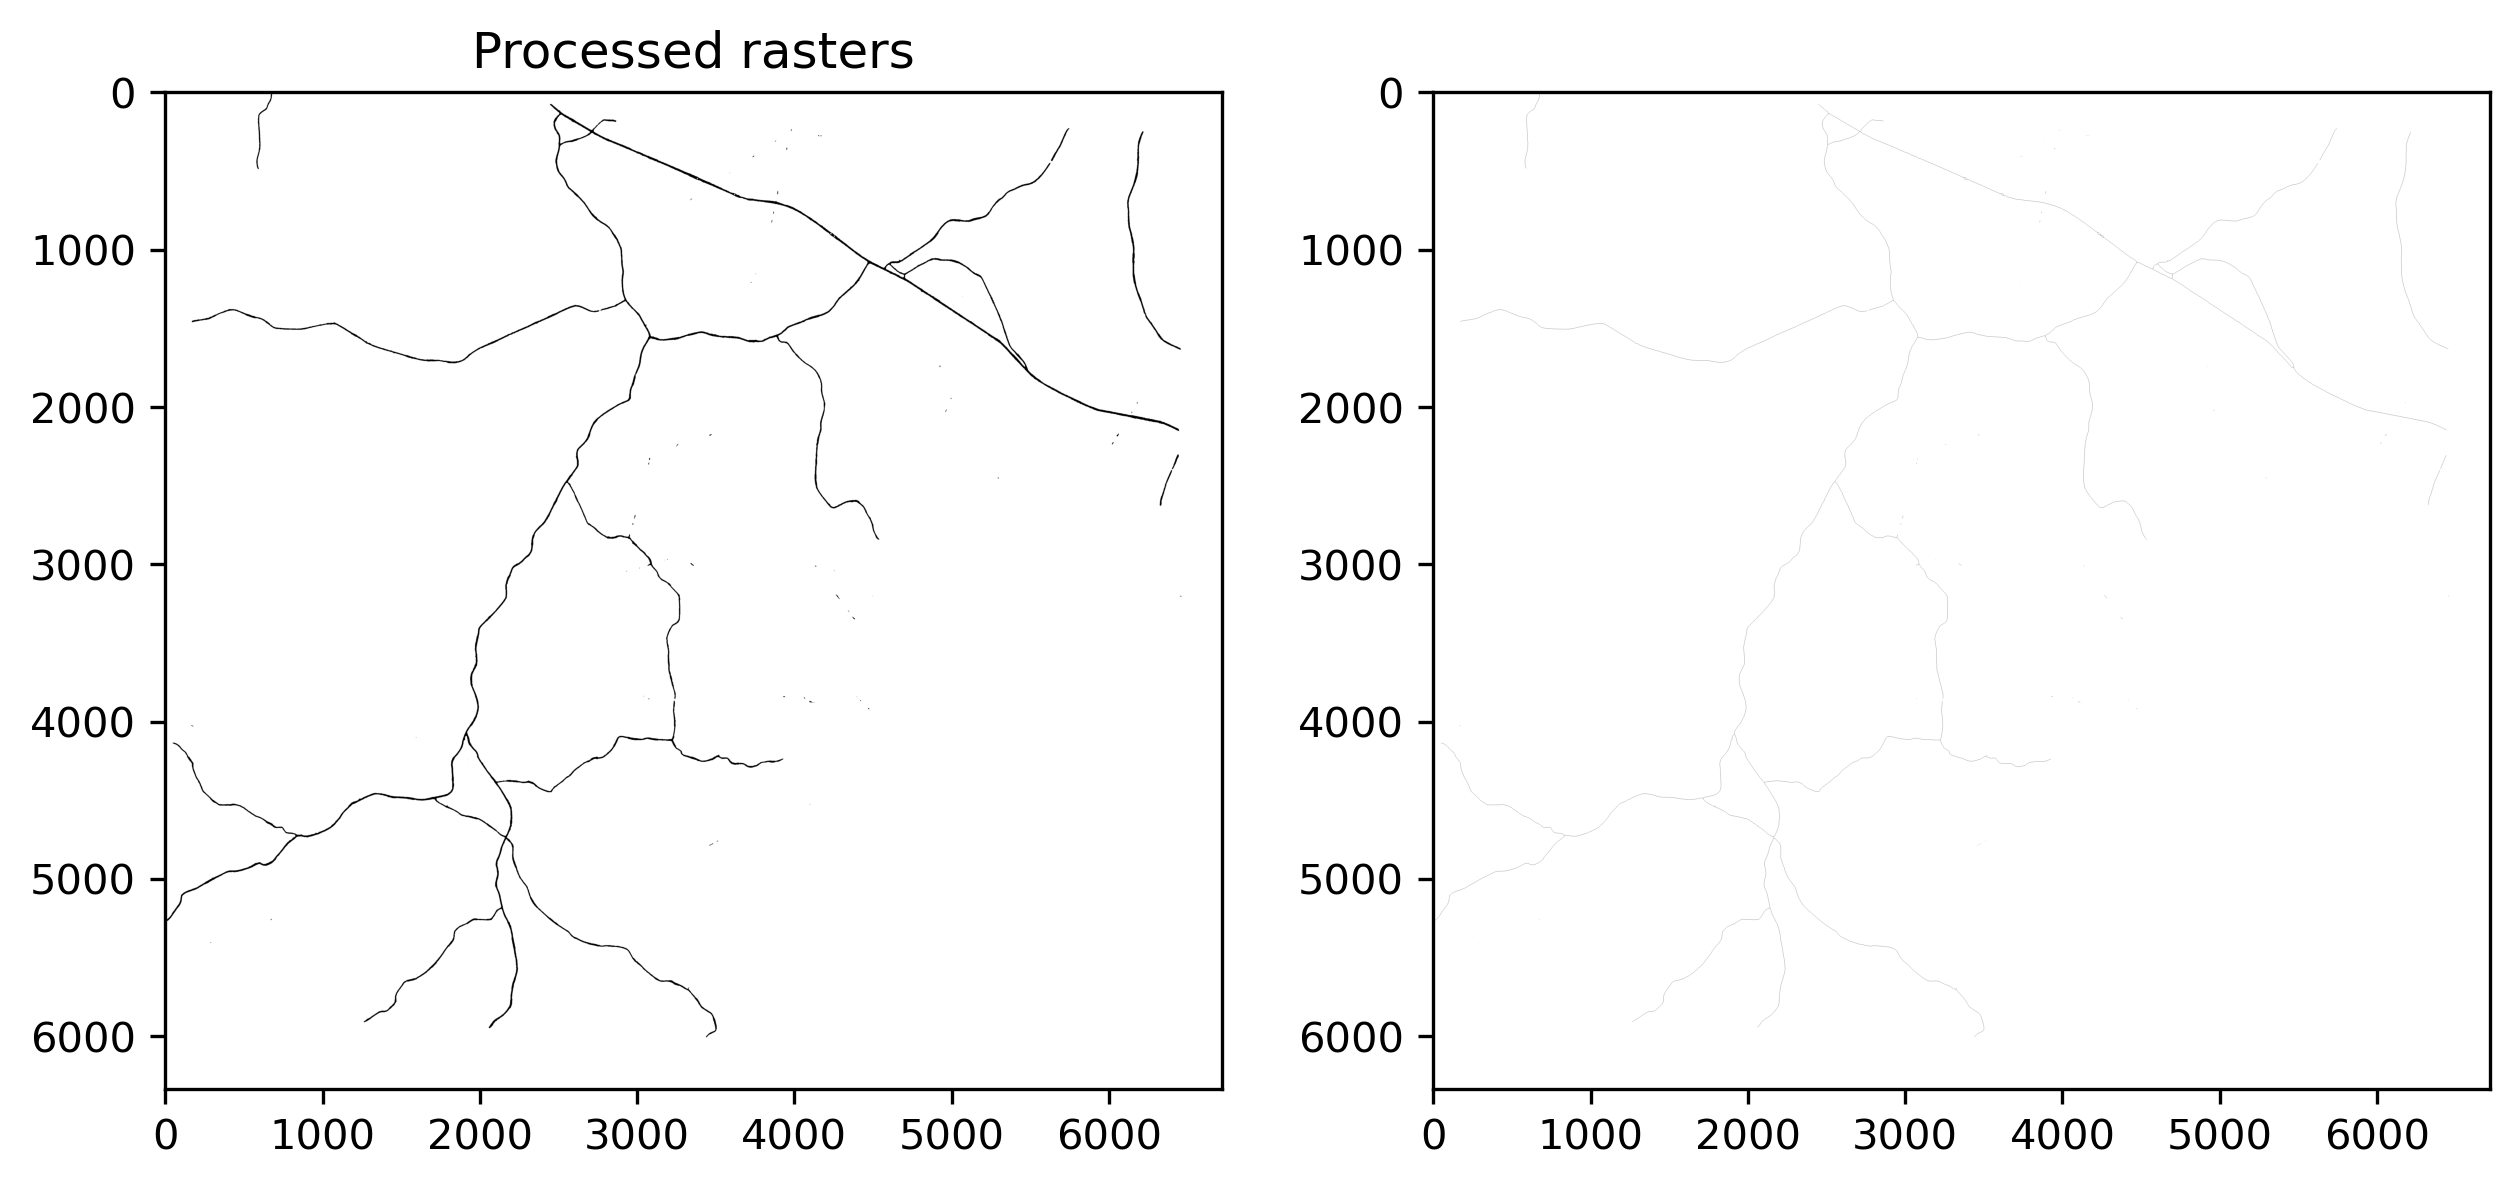

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300)
axs[0].imshow(road_data, cmap='binary')
axs[0].set_title('Processed rasters')
axs[1].imshow(skeletonize(cv2.erode(road_data, np.ones((3,3), np.uint8), iterations=1)), cmap='binary')
plt.show()

Then data are converted to polygons, buffered and merged, and `centerline.geometry.Centerline` is used to get line geometries from the data.

<AxesSubplot: >

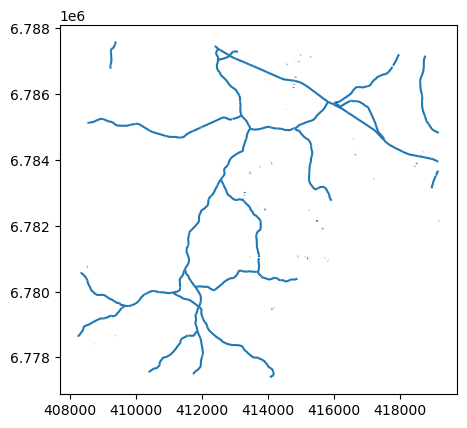

In [ ]:
polys = gpd.read_file('../results/polygons/roads/213411_1965.geojson')
lines = gpd.read_file('../results/lines/roads/213411_1965.geojson')
lines.plot()

As there were still some faulty locations (remnants from red numbers, for instance), we removed all line segments that were less than 100 meters long.

<AxesSubplot: >

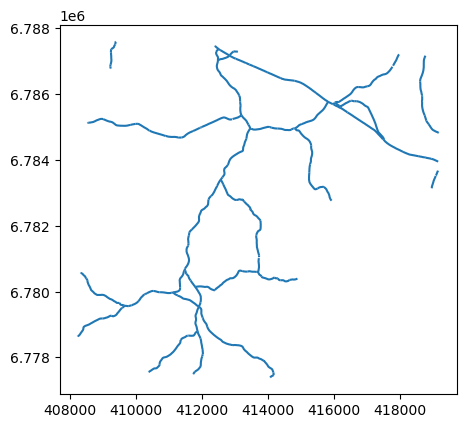

In [ ]:
lines[lines.length > 100].plot()

## Watercourses

Skeletonizing

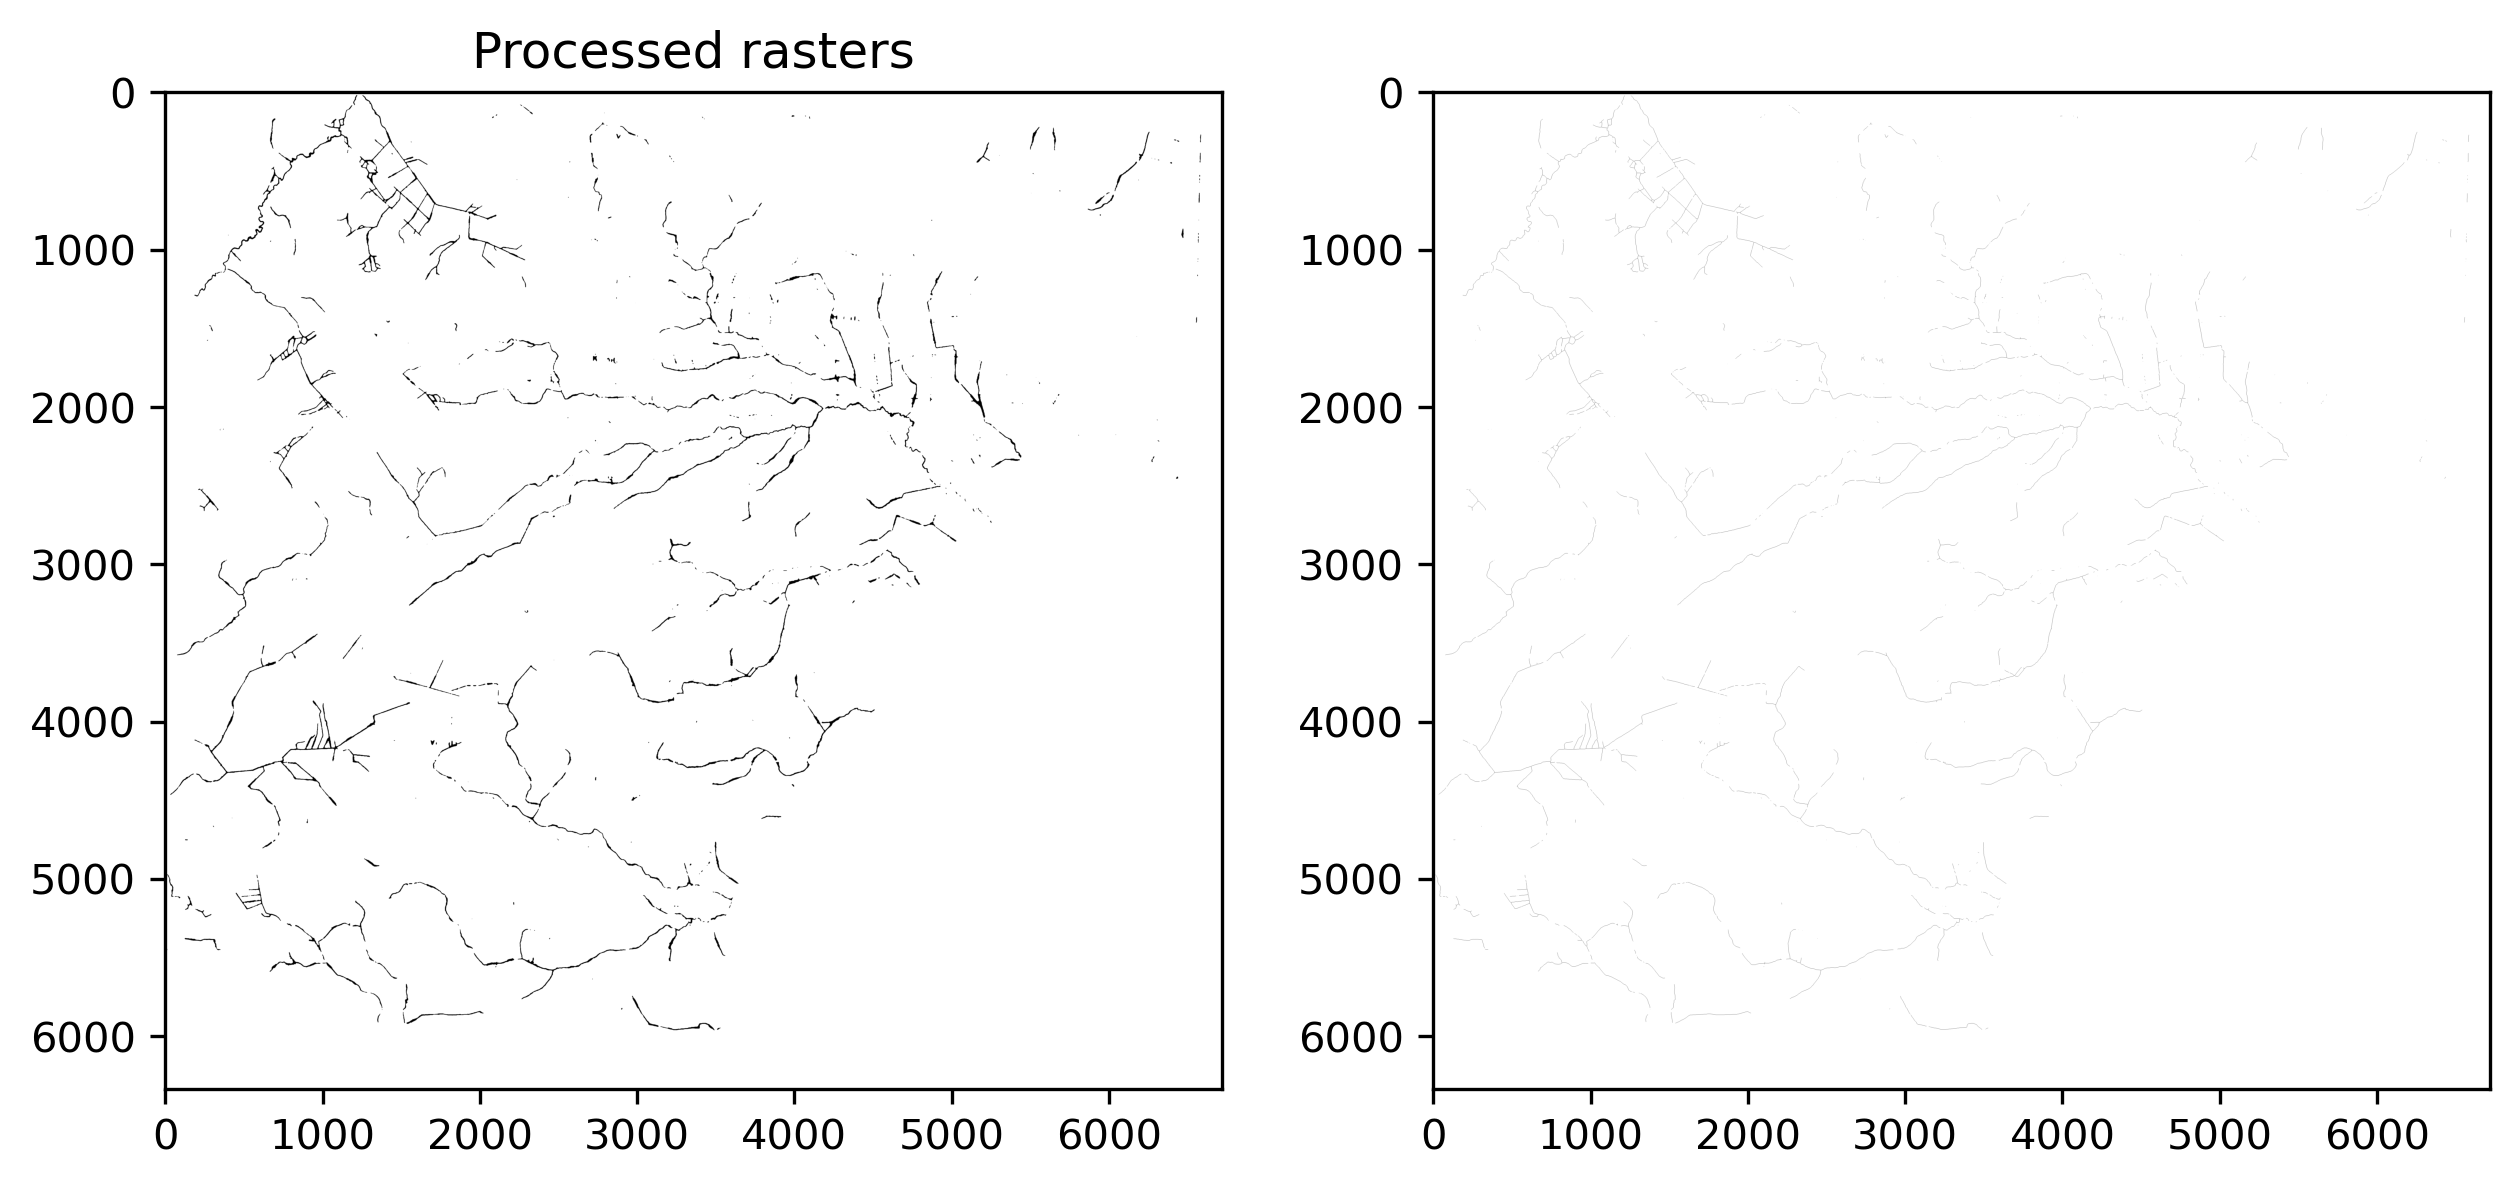

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300)
axs[0].imshow(ww_data, cmap='binary')
axs[0].set_title('Processed rasters')
axs[1].imshow(skeletonize(cv2.erode(ww_data, np.ones((3,3), np.uint8), iterations=1)), cmap='binary')
plt.show()

<AxesSubplot: >

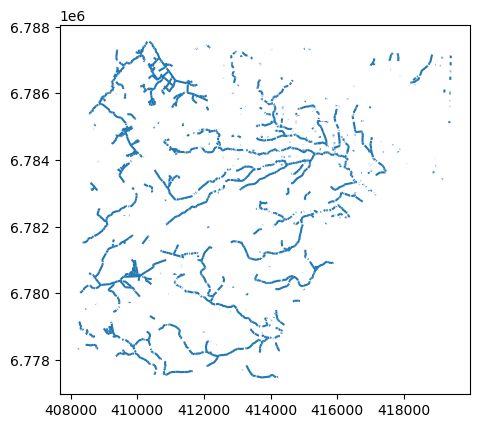

In [ ]:
polys = gpd.read_file('../results/polygons/watercourses/213411_1965.geojson')
lines = gpd.read_file('../results/lines/watercourses/213411_1965.geojson')
lines.plot()

# Compare predicted and annotated total area and length

In [ ]:
respath = Path('../results/processed/')
results = os.listdir(respath)

In [ ]:
from centerline.geometry import Centerline

In [ ]:
def simplify_lines(row):
    try:
        return shapely.ops.linemerge(row).simplify(1)
    except:
        return row.simplify(1)

def run_processing_chain(f, data_dir, skel_dir, poly_dir, line_dir, target_class):
    print(f'Processing file {f}')
    with rio.open(data_dir/f) as src:
        prof = src.profile
        im = np.where(src.read()[0] == target_class, 1, 0).astype(np.uint8)
    temp = np.zeros(im.shape)
    im = cv2.erode(im, np.ones((3,3), np.uint8), iterations=1)
    skeletonized = skeletonize(im)
    prof.update({'count':1})
    with rio.open(skel_dir/f, 'w', **prof) as dest:
        dest.write(skeletonized[None])
    with rio.open(skel_dir/f) as src:
        im = src.read(1)
        mask = im == 1
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                   for i, (s, v) in enumerate(features.shapes(im,mask=mask,transform=src.transform)))
        with fiona.open(str(poly_dir/f.replace('tif', 'geojson')), 
                        'w', driver='GeoJSON',
                        crs='EPSG:3067',
                        schema={'properties': [('raster_val', 'int')],
                                'geometry': 'Polygon'}) as dst:
            dst.writerecords(results)
    polys = gpd.read_file(poly_dir/f.replace('tif', 'geojson'))
    polys['geometry'] = polys.geometry.buffer(10)
    union_geoms = polys.geometry.unary_union
    union_gdf = gpd.GeoDataFrame({'geometry': union_geoms}, crs=polys.crs)
    union_gdf['geometry'] = union_gdf.geometry.buffer(-10)
    union_gdf['geometry'] = union_gdf.geometry.simplify(1)
    union_gdf.to_file(poly_dir/f.replace('tif', 'geojson'))

    lines = union_gdf.copy()
    lines['geometry'] = lines.geometry.apply(lambda row: Centerline(row))
    lines['geometry'] = lines.geometry.apply(lambda row: simplify_lines(row))
    lines.to_file(line_dir/f.replace('tif', 'geojson'))

In [ ]:
data_dir = Path('../data/reference_masks/')
skel_dir = Path('../data/reference_masks/skel')
poly_dir = Path('../data/reference_masks/polydata/')
line_dir = Path('../data/reference_masks/linedata/')
#run_processing_chain('val_mask_1965.tif', data_dir, skel_dir/'roads', poly_dir/'roads', line_dir/'roads', 3)
#run_processing_chain('val_mask_1965.tif', data_dir, skel_dir/'watercourses', poly_dir/'watercourses', 
#                     line_dir/'watercourses', 4)
#run_processing_chain('val_mask_1984.tif', data_dir, skel_dir/'roads', poly_dir/'roads', line_dir/'roads', 3)
#run_processing_chain('val_mask_1984.tif', data_dir, skel_dir/'watercourses', poly_dir/'watercourses', 
#                     line_dir/'watercourses', 4)

Processing file val_mask_1984.tif
Processing file val_mask_1984.tif


In [ ]:
respath = Path('../results/processed/')
polypath = Path('../results/validation_polys/')
refpath = Path('../data/reference_masks/')
linepath = Path('../results/lines/')
ref_linepath = Path('../data/reference_masks/linedata/')

## Fields

In [ ]:
for r in ['213405_1965.tif', '213405_1984.tif']:
    polygonize(respath/r, polypath/'fields'/r.replace('tif', 'geojson'), target_class=1, scale_factor=1/2)

for r in ['val_mask_1965.tif', 'val_mask_1984.tif']:
    polygonize(refpath/'postproc'/r, refpath/'polydata/fields'/r.replace('tif', 'geojson'), target_class=1, scale_factor=1/2)

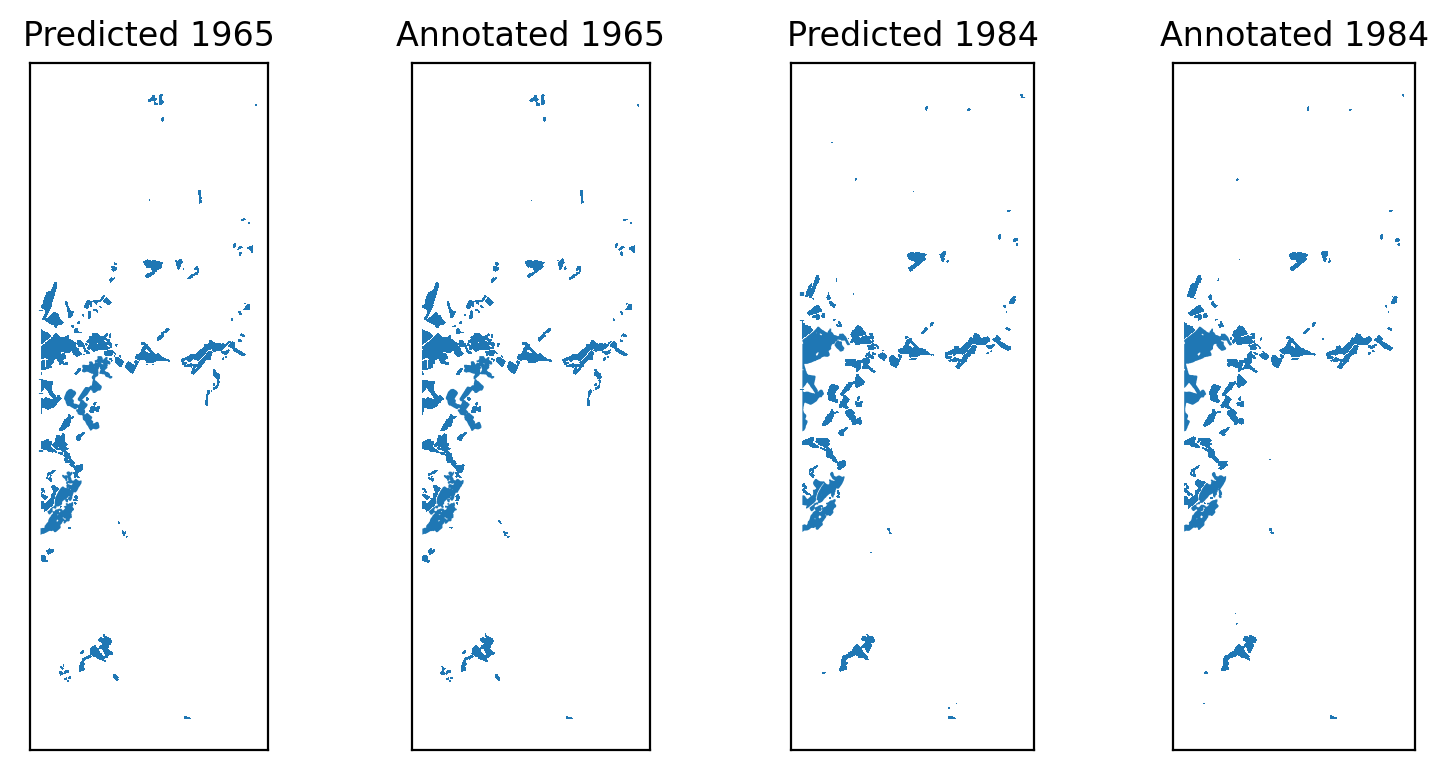

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(8,4), dpi=200)

for a in axs: 
    a.set_xticks([])
    a.set_yticks([])

pred_fields_65 = gpd.read_file(polypath/'fields/213405_1965.geojson')
ref_fields_65 = gpd.read_file(refpath/'polydata/fields/val_mask_1965.geojson')
pred_fields_65 = pred_fields_65.clip(box(*ref_fields_65.total_bounds))
pred_fields_65.plot(ax=axs[0]).set_title('Predicted 1965')
ref_fields_65 = ref_fields_65.clip(box(*pred_fields_65.total_bounds))
ref_fields_65.plot(ax=axs[1]).set_title('Annotated 1965')
pred_fields_84 = gpd.read_file(polypath/'fields/213405_1984.geojson')
ref_fields_84 = gpd.read_file(refpath/'polydata/fields/val_mask_1984.geojson')
pred_fields_84 = pred_fields_84.clip(box(*ref_fields_84.total_bounds))
pred_fields_84.plot(ax=axs[2]).set_title('Predicted 1984')
ref_fields_84 = ref_fields_84.clip(box(*pred_fields_84.total_bounds))
ref_fields_84.plot(ax=axs[3]).set_title('Annotated 1984')

plt.tight_layout()

In [ ]:
print(f'Total predicted field area in 1965: {pred_fields_65.area.sum()*10**-6:.3f} km²')
print(f'Total annotated field area in 1965: {ref_fields_65.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(pred_fields_65.area.sum()*10**-6 - ref_fields_65.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(pred_fields_65.area.sum()*10**-6 - ref_fields_65.area.sum()*10**-6)/(ref_fields_65.area.sum()*10**-6):.3f} %')

Total predicted field area in 1965: 2.072 km²
Total annotated field area in 1965: 2.102 km²
Difference in km²: -0.030 km²
%-difference: -1.409 %


In [ ]:
print(f'Total predicted field area in 1984: {pred_fields_84.area.sum()*10**-6:.3f} km²')
print(f'Total annotated field area in 1984: {ref_fields_84.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(pred_fields_84.area.sum()*10**-6 - ref_fields_84.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(pred_fields_84.area.sum()*10**-6 - ref_fields_84.area.sum()*10**-6)/(ref_fields_84.area.sum()*10**-6):.3f} %')

Total predicted field area in 1984: 1.749 km²
Total annotated field area in 1984: 1.769 km²
Difference in km²: -0.020 km²
%-difference: -1.120 %


## Mires

In [ ]:
for r in ['213405_1965.tif', '213405_1984.tif']:
    polygonize(respath/r, polypath/'mires'/r.replace('tif', 'geojson'), target_class=2, scale_factor=1/2)

for r in ['val_mask_1965.tif', 'val_mask_1984.tif']:
    polygonize(refpath/'postproc'/r, refpath/'polydata/mires'/r.replace('tif', 'geojson'), target_class=2, scale_factor=1/2)

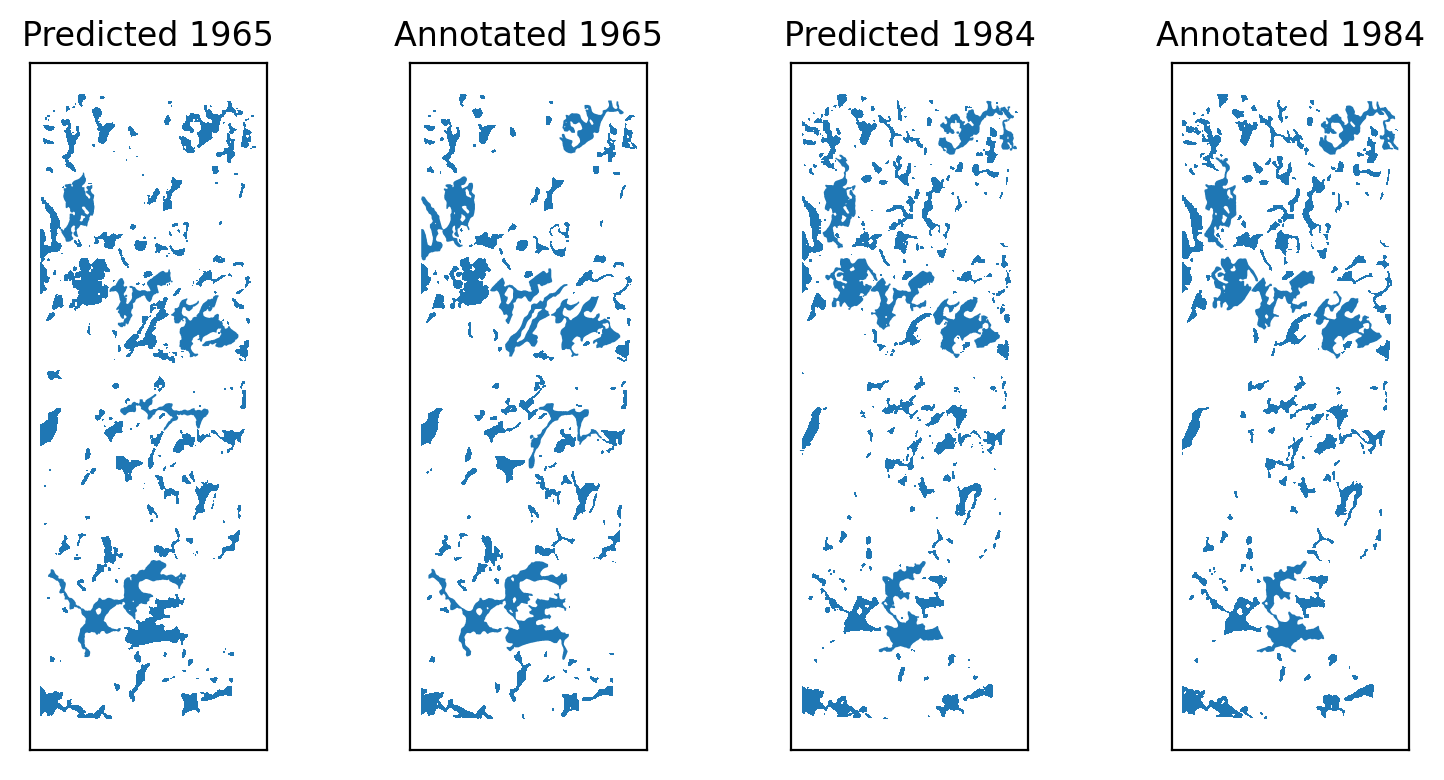

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(8,4), dpi=200)

for a in axs: 
    a.set_xticks([])
    a.set_yticks([])

pred_mires_65 = gpd.read_file(polypath/'mires/213405_1965.geojson')
ref_mires_65 = gpd.read_file(refpath/'polydata/mires/val_mask_1965.geojson')
pred_mires_65 = pred_mires_65.clip(box(*ref_mires_65.total_bounds))
pred_mires_65.plot(ax=axs[0]).set_title('Predicted 1965')
ref_mires_65 = ref_mires_65.clip(box(*pred_mires_65.total_bounds))
ref_mires_65.plot(ax=axs[1]).set_title('Annotated 1965')
pred_mires_84 = gpd.read_file(polypath/'mires/213405_1984.geojson')
ref_mires_84 = gpd.read_file(refpath/'polydata/mires/val_mask_1984.geojson')
pred_mires_84 = pred_mires_84.clip(box(*ref_mires_84.total_bounds))
pred_mires_84.plot(ax=axs[2]).set_title('Predicted 1984')
ref_mires_84 = ref_mires_84.clip(box(*pred_mires_84.total_bounds))
ref_mires_84.plot(ax=axs[3]).set_title('Annotated 1984')

plt.tight_layout()

In [ ]:
print(f'Total predicted mire area in 1965: {pred_mires_65.area.sum()*10**-6:.3f} km²')
print(f'Total annotated mire area in 1965: {ref_mires_65.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(pred_mires_65.area.sum()*10**-6 - ref_mires_65.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(pred_mires_65.area.sum()*10**-6 - ref_mires_65.area.sum()*10**-6)/(ref_mires_65.area.sum()*10**-6):.3f} %')

Total predicted mire area in 1965: 5.789 km²
Total annotated mire area in 1965: 5.919 km²
Difference in km²: -0.129 km²
%-difference: -2.182 %


In [ ]:
print(f'Total predicted mire area in 1984: {pred_mires_84.area.sum()*10**-6:.3f} km²')
print(f'Total annotated mire area in 1984: {ref_mires_84.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(pred_mires_84.area.sum()*10**-6 - ref_mires_84.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(pred_mires_84.area.sum()*10**-6 - ref_mires_84.area.sum()*10**-6)/(ref_mires_84.area.sum()*10**-6):.3f} %')

Total predicted mire area in 1984: 5.804 km²
Total annotated mire area in 1984: 6.001 km²
Difference in km²: -0.196 km²
%-difference: -3.270 %


## Roads

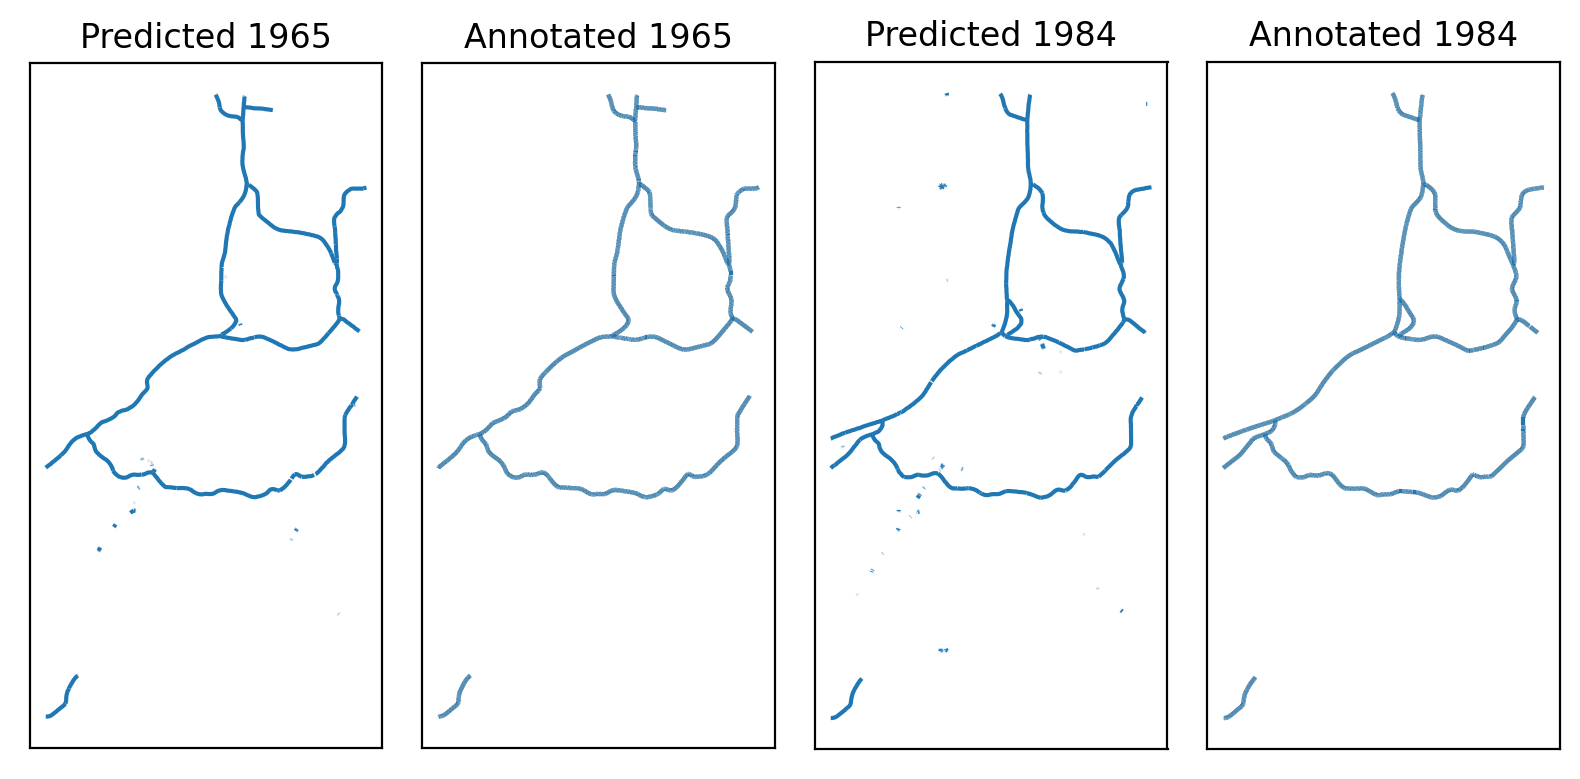

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(8,4), dpi=200)

for a in axs: 
    a.set_xticks([])
    a.set_yticks([])

pred_roads_65 = gpd.read_file(linepath/'roads/213405_1965.geojson')
ref_roads_65 = gpd.read_file(ref_linepath/'roads/val_mask_1965.geojson')
pred_roads_65 = pred_roads_65.clip(box(*ref_roads_65.total_bounds))
pred_roads_65.plot(ax=axs[0]).set_title('Predicted 1965')
ref_roads_65 = ref_roads_65.clip(box(*pred_roads_65.total_bounds))
ref_roads_65.plot(ax=axs[1]).set_title('Annotated 1965')
pred_roads_84 = gpd.read_file(linepath/'roads/213405_1984.geojson')
ref_roads_84 = gpd.read_file(ref_linepath/'roads/val_mask_1984.geojson')
pred_roads_84 = pred_roads_84.clip(box(*ref_roads_84.total_bounds))
pred_roads_84.plot(ax=axs[2]).set_title('Predicted 1984')
ref_roads_84 = ref_roads_84.clip(box(*pred_roads_84.total_bounds))
ref_roads_84.plot(ax=axs[3]).set_title('Annotated 1984')

plt.tight_layout()

In [ ]:
print(f'Total predicted road length in 1965: {pred_roads_65.length.sum()*10**-3:.3f} km')
print(f'Total annotated road length in 1965: {ref_roads_65.length.sum()*10**-3:.3f} km')
print(f'Difference in km: {(pred_roads_65.length.sum()*10**-3 - ref_roads_65.length.sum()*10**-3):.3f} km')
print(f'%-difference: {100*(pred_roads_65.length.sum()*10**-3 - ref_roads_65.length.sum()*10**-3)/(ref_roads_65.length.sum()*10**-3):.3f} %')

Total predicted road length in 1965: 15.759 km
Total annotated road length in 1965: 15.612 km
Difference in km: -0.147 km
%-difference: -0.943 %


In [ ]:
print(f'Total predicted road length in 1984: {pred_roads_84.length.sum()*10**-3:.3f} km')
print(f'Total annotated road length in 1984: {ref_roads_84.length.sum()*10**-3:.3f} km')
print(f'Difference in km: {(ref_roads_84.length.sum()*10**-3 - pred_roads_84.length.sum()*10**-3):.3f} km')
print(f'%-difference: {100*(ref_roads_84.length.sum()*10**-3 - pred_roads_84.length.sum()*10**-3)/(ref_roads_84.length.sum()*10**-3):.3f} %')

Total predicted road length in 1984: 16.832 km
Total annotated road length in 1984: 16.200 km
Difference in km: -0.632 km
%-difference: -3.900 %


## Watercourses

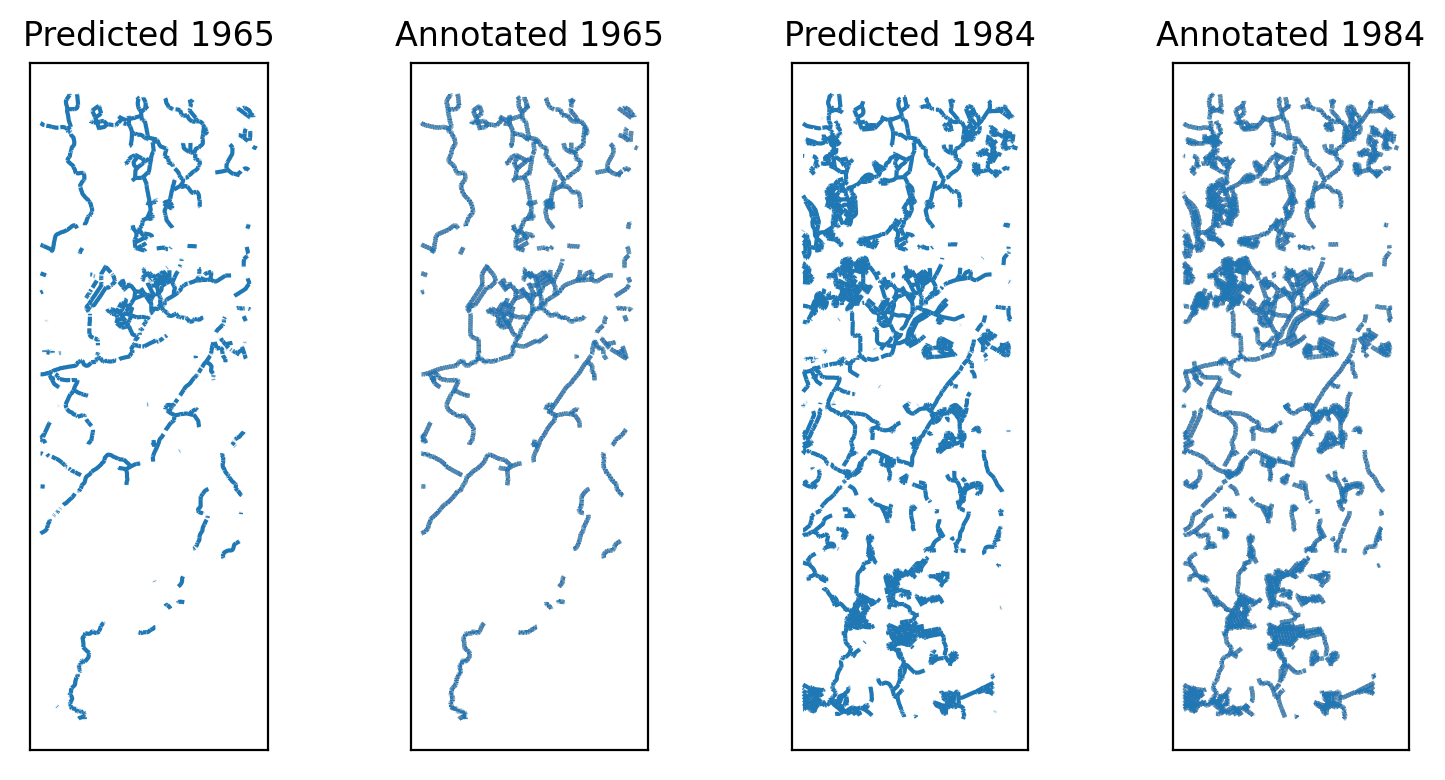

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(8,4), dpi=200)

for a in axs: 
    a.set_xticks([])
    a.set_yticks([])

pred_watercourses_65 = gpd.read_file(linepath/'watercourses/213405_1965.geojson')
ref_watercourses_65 = gpd.read_file(ref_linepath/'watercourses/val_mask_1965.geojson')
pred_watercourses_65 = pred_watercourses_65.clip(box(*ref_watercourses_65.total_bounds))
pred_watercourses_65.plot(ax=axs[0]).set_title('Predicted 1965')
ref_watercourses_65 = ref_watercourses_65.clip(box(*pred_watercourses_65.total_bounds))
ref_watercourses_65.plot(ax=axs[1]).set_title('Annotated 1965')
pred_watercourses_84 = gpd.read_file(linepath/'watercourses/213405_1984.geojson')
ref_watercourses_84 = gpd.read_file(ref_linepath/'watercourses/val_mask_1984.geojson')
pred_watercourses_84 = pred_watercourses_84.clip(box(*ref_watercourses_84.total_bounds))
pred_watercourses_84.plot(ax=axs[2]).set_title('Predicted 1984')
ref_watercourses_84 = ref_watercourses_84.clip(box(*pred_watercourses_84.total_bounds))
ref_watercourses_84.plot(ax=axs[3]).set_title('Annotated 1984')

plt.tight_layout()

In [ ]:
print(f'Total predicted watercourse length in 1965: {pred_watercourses_65.length.sum()*10**-3:.3f} km')
print(f'Total annotated watercourse length in 1965: {ref_watercourses_65.length.sum()*10**-3:.3f} km')
print(f'Difference in km: {(ref_watercourses_65.length.sum()*10**-3 - pred_watercourses_65.length.sum()*10**-3):.3f} km')
print(f'%-difference: {100*(ref_watercourses_65.length.sum()*10**-3 - pred_watercourses_65.length.sum()*10**-3)/(ref_watercourses_65.length.sum()*10**-3):.3f} %')

Total predicted watercourse length in 1965: 55.786 km
Total annotated watercourse length in 1965: 59.255 km
Difference in km: 3.469 km
%-difference: 5.854 %


In [ ]:
print(f'Total predicted watercourse length in 1984: {pred_watercourses_84.length.sum()*10**-3:.3f} km')
print(f'Total annotated watercourse length in 1984: {ref_watercourses_84.length.sum()*10**-3:.3f} km')
print(f'Difference in km: {(ref_watercourses_84.length.sum()*10**-3 - pred_watercourses_84.length.sum()*10**-3):.3f} km')
print(f'%-difference: {100*(ref_watercourses_84.length.sum()*10**-3 - pred_watercourses_84.length.sum()*10**-3)/(ref_watercourses_84.length.sum()*10**-3):.3f} %')

Total predicted watercourse length in 1984: 160.470 km
Total annotated watercourse length in 1984: 164.801 km
Difference in km: 4.332 km
%-difference: 2.628 %


## Water bodies

In [ ]:
for r in ['213405_1965.tif', '213405_1984.tif']:
    polygonize(respath/r, polypath/'water_bodies'/r.replace('tif', 'geojson'), target_class=5, scale_factor=1/2)

for r in ['val_mask_1965.tif', 'val_mask_1984.tif']:
    polygonize(refpath/'postproc'/r, refpath/'polydata/water_bodies'/r.replace('tif', 'geojson'), target_class=5, scale_factor=1/2)

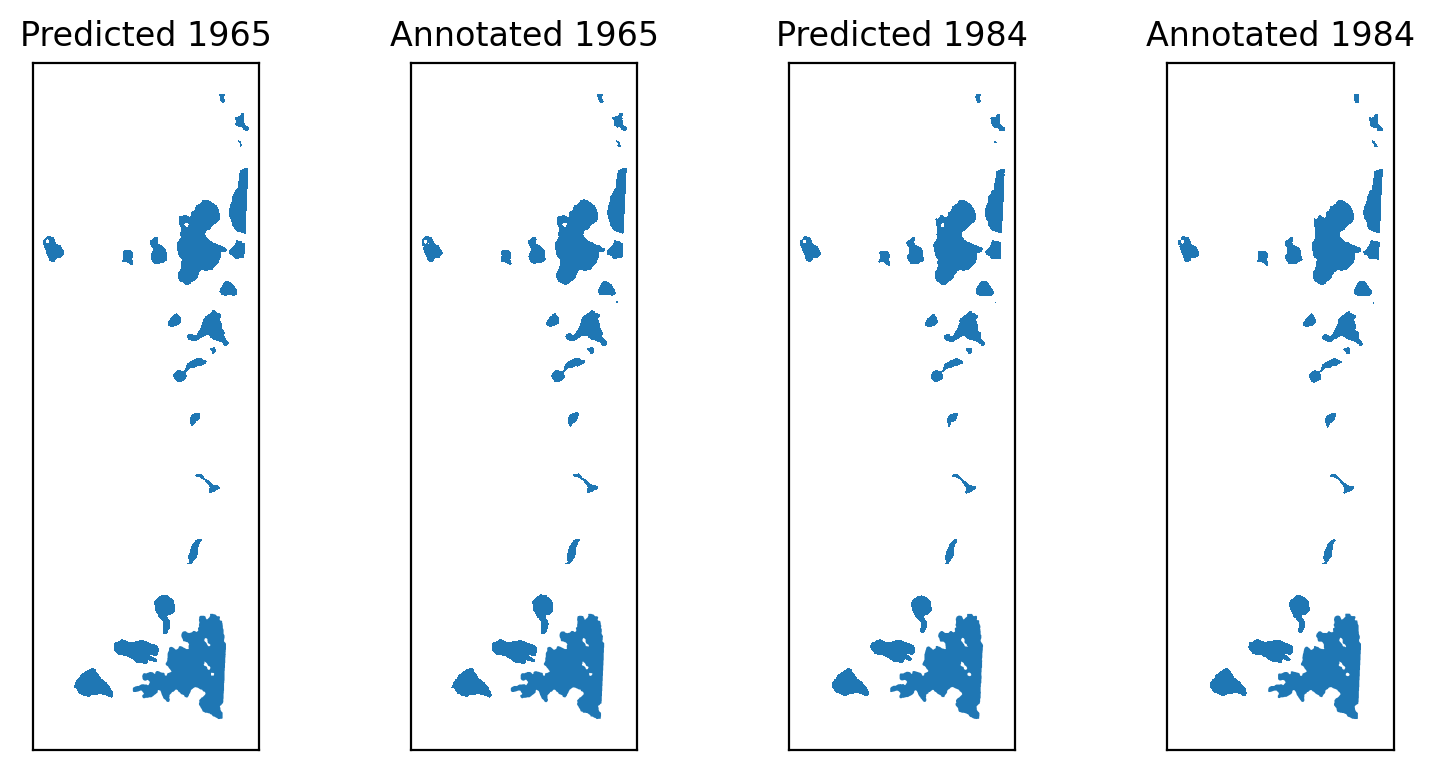

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(8,4), dpi=200)

for a in axs: 
    a.set_xticks([])
    a.set_yticks([])

pred_water_bodies_65 = gpd.read_file(polypath/'water_bodies/213405_1965.geojson')
ref_water_bodies_65 = gpd.read_file(refpath/'polydata/water_bodies/val_mask_1965.geojson')
pred_water_bodies_65 = pred_water_bodies_65.clip(box(*ref_water_bodies_65.total_bounds))
pred_water_bodies_65.plot(ax=axs[0]).set_title('Predicted 1965')
ref_water_bodies_65 = ref_water_bodies_65.clip(box(*pred_water_bodies_65.total_bounds))
ref_water_bodies_65.plot(ax=axs[1]).set_title('Annotated 1965')
pred_water_bodies_84 = gpd.read_file(polypath/'water_bodies/213405_1984.geojson')
ref_water_bodies_84 = gpd.read_file(refpath/'polydata/water_bodies/val_mask_1984.geojson')
pred_water_bodies_84 = pred_water_bodies_84.clip(box(*ref_water_bodies_84.total_bounds))
pred_water_bodies_84.plot(ax=axs[2]).set_title('Predicted 1984')
ref_water_bodies_84 = ref_water_bodies_84.clip(box(*pred_water_bodies_84.total_bounds))
ref_water_bodies_84.plot(ax=axs[3]).set_title('Annotated 1984')

plt.tight_layout()

In [ ]:
print(f'Total predicted water body area in 1965: {pred_water_bodies_65.area.sum()*10**-6:.3f} km²')
print(f'Total annotated water body area in 1965: {ref_water_bodies_65.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(ref_water_bodies_65.area.sum()*10**-6 - pred_water_bodies_65.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(ref_water_bodies_65.area.sum()*10**-6 - pred_water_bodies_65.area.sum()*10**-6)/(ref_water_bodies_65.area.sum()*10**-6):.3f} %')

Total predicted water body area in 1965: 2.519 km²
Total annotated water body area in 1965: 2.530 km²
Difference in km²: 0.011 km²
%-difference: 0.449 %


In [ ]:
print(f'Total predicted water body area in 1984: {pred_water_bodies_84.area.sum()*10**-6:.3f} km²')
print(f'Total annotated water body area in 1984: {ref_water_bodies_84.area.sum()*10**-6:.3f} km²')
print(f'Difference in km²: {(ref_water_bodies_84.area.sum()*10**-6 - pred_water_bodies_84.area.sum()*10**-6):.3f} km²')
print(f'%-difference: {100*(ref_water_bodies_84.area.sum()*10**-6 - pred_water_bodies_84.area.sum()*10**-6)/(ref_water_bodies_84.area.sum()*10**-6):.3f} %')

Total predicted water body area in 1984: 2.463 km²
Total annotated water body area in 1984: 2.462 km²
Difference in km²: -0.002 km²
%-difference: -0.069 %
